## How much tracer is there on the shelf?

This notebook explores the effects of changing the initial tracer profile on the total amount of tracer (mass) on the shelf at a certain time and place.

In [3]:
#import gsw as sw # Gibbs seawater package

from math import *

import matplotlib.pyplot as plt

import matplotlib.colors as mcolors

%matplotlib inline

from MITgcmutils import rdmds

from netCDF4 import Dataset

import numpy as np

import os 

import pylab as pl

import scipy.io

import scipy as spy

import seaborn as sns

import sys

In [4]:
lib_path = os.path.abspath('../../Building_canyon/BuildCanyon/PythonModulesMITgcm') # Add absolute path to my python scripts
sys.path.append(lib_path)

import ReadOutTools_MITgcm as rout 


In [5]:
sns.set()
sns.set_style('darkgrid')
sns.set_context('talk')

In [6]:
#Exp
CGrid = '/ocean/kramosmu/MITgcm/TracerExperiments/BARKLEY/run01/gridGlob.nc' # Smallest volume grid, closed bdy, no canyon.
CGridOut = Dataset(CGrid)

BARrun01 = '/ocean/kramosmu/MITgcm/TracerExperiments/BARKLEY/run01/stateGlob.nc'
StateOut01 = Dataset(BARrun01)

TRArun01 = '/ocean/kramosmu/MITgcm/TracerExperiments/BARKLEY/run01/ptracersGlob.nc'
PtracersOut01 = Dataset(TRArun01)



In [7]:
# General input

nx = 360
ny = 360
nz = 90
nt = 19 # t dimension size 

rc = CGridOut.variables['RC']
xc = rout.getField(CGrid, 'XC') # x coords tracer cells
yc = rout.getField(CGrid, 'YC') # y coords tracer cells

drF = CGridOut.variables['drF'] # vertical distance between faces
dxG = rout.getField(CGrid,'dxG')

MaskCan = rout.getMask(CGrid,'HFacC') 
hFacCCan = rout.getField(CGrid,'HFacC') 
rACan = rout.getField(CGrid,'rA') 
drFCan= CGridOut.variables['drF']


In [8]:
print(rc[50])

-410.0


In [9]:
# Load tracers 
Tr1 = rout.getField(TRArun01,'Tr01')
Tr2 = rout.getField(TRArun01,'Tr02') 
Tr3 = rout.getField(TRArun01,'Tr03') 
Tr4 = rout.getField(TRArun01,'Tr04') 


In [10]:
Tr5 = rout.getField(TRArun01,'Tr05') 
Tr6 = rout.getField(TRArun01,'Tr06') 
Tr7 = rout.getField(TRArun01,'Tr07') 
Tr8 = rout.getField(TRArun01,'Tr08') 


In [11]:
Tr1ini = Tr1[0,:,50,180]
Tr2ini = Tr2[0,:,50,180]
Tr3ini = Tr3[0,:,50,180]
Tr4ini = Tr4[0,:,50,180]
Tr5ini = Tr5[0,:,50,180]
Tr6ini = Tr6[0,:,50,180]
Tr7ini = Tr7[0,:,50,180]
Tr8ini = Tr8[0,:,50,180]


### How much water with concentration higher than a limit is there on the shelf at each time? How much tracer mass?

In [12]:
def HowMuchWaterX(Tr,MaskC,nzlim,rA,hFacC,drF,yin,zfin):
    '''
    INPUT----------------------------------------------------------------------------------------------------------------
    Tr    : Array with concentration values for a tracer. Until this function is more general, this should be size 19x90x360x360
    MaskC : Land mask for tracer
    nzlim : The nz index under which to look for water properties
    rA    : Area of cell faces at C points (360x360)
    fFacC : Fraction of open cell (90x360x360)
    drF   : Distance between cell faces (90)
    yin   : across-shore index of shelf break
    zfin  : shelf break index + 1 
    OUTPUT----------------------------------------------------------------------------------------------------------------
    VolWaterHighConc =  Array with the volume of water over the shelf [:,:30,227:,:] at every time output.
    Total_Tracer =  Array with the mass of tracer (Mol) at each x-position over the shelf [:,:30,227:,:] at every time output.
          Total mass of tracer at xx on the shelf.
                                                
    -----------------------------------------------------------------------------------------------------------------------
    '''
    mask_expand = np.expand_dims(MaskC,0)
    mask_expand = mask_expand + np.zeros(Tr.shape)

    TrMask0=np.ma.array(Tr[0,:,:,:],mask=mask_expand[0,:,:,:])
        
    trlim = TrMask0[nzlim,50,180]
    
    hFacCSwap = np.swapaxes(hFacC, 0, 2)
    
    print('tracer limit is: ',trlim)
    
    TrMask=np.ma.array(Tr,mask=mask_expand)
    
    WaterX = 0
    
    # mask cells with tracer concentration < trlim on shelf
    HighConc_Masked = np.ma.masked_less(TrMask[:,:zfin,yin:,:], trlim) 
    HighConc_Mask = HighConc_Masked.mask
    
    #Get volume of water of cells with relatively high concentration
    rA_exp = np.expand_dims(rA[yin:,:],0)
    drF_exp = np.expand_dims(np.expand_dims(drF[:zfin],1),1)
    rA_exp = rA_exp + np.zeros(hFacC[:zfin,yin:,:].shape)
    drF_exp = drF_exp + np.zeros(hFacC[:zfin,yin:,:].shape)
    
    ShelfVolume = hFacC[:zfin,yin:,:]*drF_exp*rA_exp
    ShelfVolume_exp = np.expand_dims(ShelfVolume,0)
    ShelfVolume_exp = ShelfVolume_exp + np.zeros(HighConc_Mask.shape)
    
    HighConc_CellVol = np.ma.masked_array(ShelfVolume_exp,mask = HighConc_Mask) 
    VolWaterHighConc = np.ma.sum(np.ma.sum(np.ma.sum(HighConc_CellVol,axis = 1),axis=1),axis=1)
    
    
    
    #Get total mass of tracer on shelf
    Total_Tracer = np.ma.sum(np.ma.sum(np.ma.sum(ShelfVolume_exp*TrMask[:,:zfin,yin:,:]*1000.0,axis = 1),axis=1),axis=1) 
    # 1 m^3 = 1000 l
    
    return (VolWaterHighConc, Total_Tracer)

### Calculate volume on shelf of high tracer concentration water and tracer mass. 

In [13]:


(WatTr1, TrMassTr1) = HowMuchWaterX(Tr1,MaskCan,30,rACan,hFacCCan,drFCan,227,30) 
(WatTr2, TrMassTr2) = HowMuchWaterX(Tr2,MaskCan,30,rACan,hFacCCan,drFCan,227,30) 
(WatTr3, TrMassTr3) = HowMuchWaterX(Tr3,MaskCan,30,rACan,hFacCCan,drFCan,227,30) 
(WatTr4, TrMassTr4) = HowMuchWaterX(Tr4,MaskCan,30,rACan,hFacCCan,drFCan,227,30) 
(WatTr5, TrMassTr5) = HowMuchWaterX(Tr5,MaskCan,30,rACan,hFacCCan,drFCan,227,30) 
(WatTr6, TrMassTr6) = HowMuchWaterX(Tr6,MaskCan,30,rACan,hFacCCan,drFCan,227,30) 
(WatTr7, TrMassTr7) = HowMuchWaterX(Tr7,MaskCan,30,rACan,hFacCCan,drFCan,227,30) 
(WatTr8, TrMassTr8) = HowMuchWaterX(Tr8,MaskCan,30,rACan,hFacCCan,drFCan,227,30) 
      
    
   

('tracer limit is: ', 32.251045)
('tracer limit is: ', 33.898914)
('tracer limit is: ', 103.13976)
('tracer limit is: ', 32.763577)
('tracer limit is: ', 47.862217)
('tracer limit is: ', 2.2521822)
('tracer limit is: ', 27.700876)
('tracer limit is: ', 19.381783)


In [14]:
print(rc[30])

-152.5


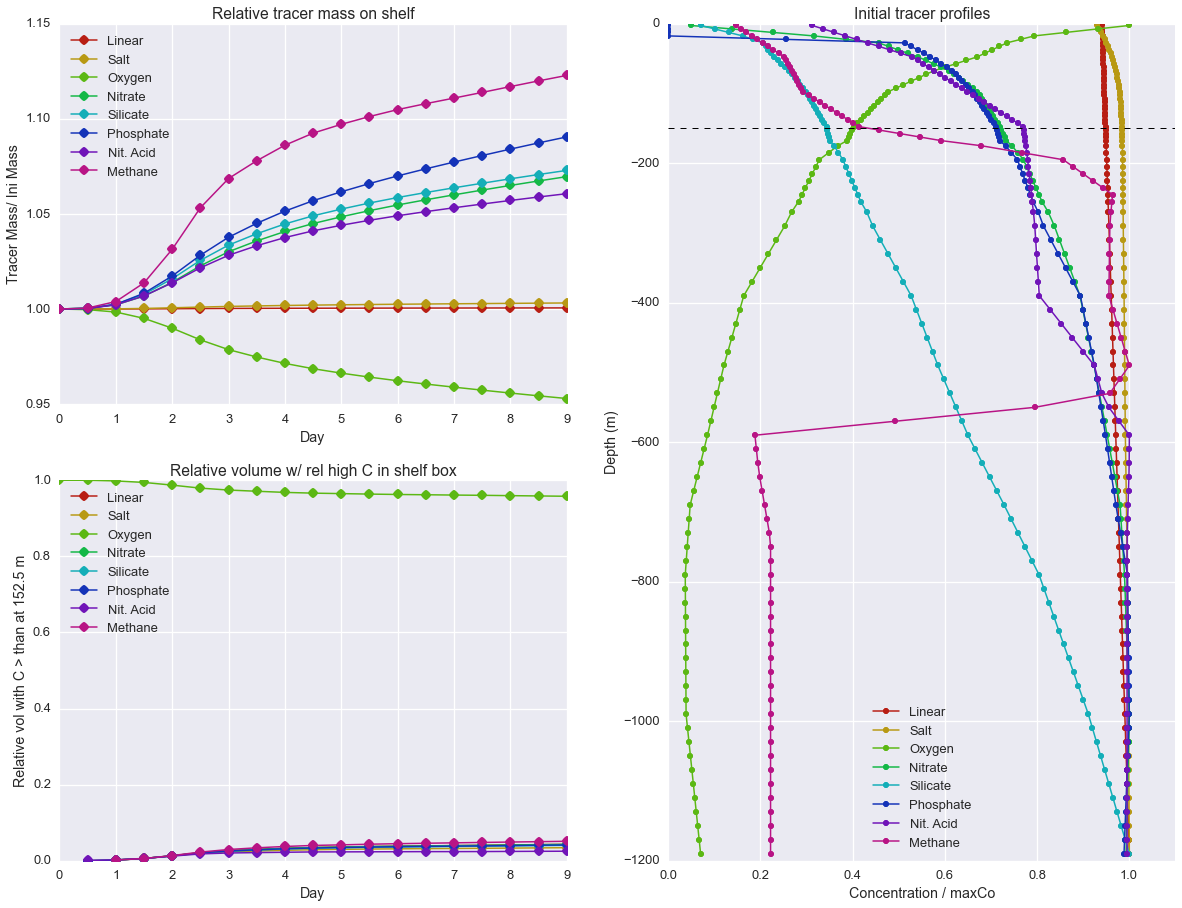

In [15]:
fig45=plt.figure(figsize=(20,15))
sns.set(context='talk', style='darkgrid', font='sans-serif', font_scale=1,rc={"lines.linewidth": 1.5})

times = np.arange(0,nt,1)

#with sns.color_palette('YlOrRd_r',8):
with sns.hls_palette(8, l=.4, s=.8):    
    ax1 = plt.subplot(2,2,1)

    line1 = ax1.plot(times/2.0, TrMassTr1/TrMassTr1[0],'o-', label='Linear')
    line2 = ax1.plot(times/2.0, TrMassTr2/TrMassTr2[0],'o-', label='Salt')
    line3 = ax1.plot(times/2.0, TrMassTr3/TrMassTr3[0],'o-', label='Oxygen')
    line4 = ax1.plot(times/2.0, TrMassTr4/TrMassTr4[0],'o-', label='Nitrate')
    line5 = ax1.plot(times/2.0, TrMassTr5/TrMassTr5[0],'o-', label='Silicate')
    line6 = ax1.plot(times/2.0, TrMassTr6/TrMassTr6[0],'o-', label='Phosphate')
    line7 = ax1.plot(times/2.0, TrMassTr7/TrMassTr7[0],'o-', label='Nit. Acid')
    line8 = ax1.plot(times/2.0, TrMassTr8/TrMassTr8[0],'o-', label='Methane')

    plt.ylabel('Tracer Mass/ Ini Mass ')
    plt.xlabel('Day')
    plt.title('Relative tracer mass on shelf')
with sns.hls_palette(8, l=.4, s=.8):
    ax2 = plt.subplot(2,2,3)

    line1 = ax2.plot(times/2.0, WatTr1/WatTr3[0],'o-',label='Linear') # Ini Oxygen volume
    line2 = ax2.plot(times/2.0, WatTr2/WatTr3[0],'o-', label='Salt')
    line3 = ax2.plot(times/2.0, WatTr3/WatTr3[0],'o-', label='Oxygen')
    line4 = ax2.plot(times/2.0, WatTr4/WatTr3[0],'o-', label='Nitrate')
    line5 = ax2.plot(times/2.0, WatTr5/WatTr3[0],'o-', label='Silicate')
    line6 = ax2.plot(times/2.0, WatTr6/WatTr3[0],'o-', label='Phosphate')
    line7 = ax2.plot(times/2.0, WatTr7/WatTr3[0],'o-', label='Nit. Acid')
    line8 = ax2.plot(times/2.0, WatTr8/WatTr3[0],'o-', label='Methane')
    
    plt.title('Relative volume w/ rel high C in shelf box')
    plt.ylabel('Relative vol with C > than at 152.5 m')
    plt.xlabel('Day')
 
with sns.hls_palette(8, l=.4, s=.8):
    ax3 = plt.subplot(2,2,(2,4))

    line1 = ax3.plot(Tr1[0,:,50,180]/np.max(Tr1[0,:,50,180]),rc[:],'o-',markersize = 6, label='Linear')
    line2 = ax3.plot(Tr2[0,:,50,180]/np.max(Tr2[0,:,50,180]),rc[:],'o-',markersize = 6, label='Salt')
    line3 = ax3.plot(Tr3[0,:,50,180]/np.max(Tr3[0,:,50,180]),rc[:],'o-',markersize = 6, label='Oxygen')
    line4 = ax3.plot(Tr4[0,:,50,180]/np.max(Tr4[0,:,50,180]),rc[:],'o-',markersize = 6, label='Nitrate')
    line5 = ax3.plot(Tr5[0,:,50,180]/np.max(Tr5[0,:,50,180]),rc[:],'o-',markersize = 6, label='Silicate')
    line6 = ax3.plot(Tr6[0,:,50,180]/np.max(Tr6[0,:,50,180]),rc[:],'o-',markersize = 6, label='Phosphate')
    line7 = ax3.plot(Tr7[0,:,50,180]/np.max(Tr7[0,:,50,180]),rc[:],'o-',markersize = 6, label='Nit. Acid')
    line8 = ax3.plot(Tr8[0,:,50,180]/np.max(Tr8[0,:,50,180]),rc[:],'o-',markersize = 6, label='Methane')
    
    ax3.set_xlim(0,1.1)
    plt.title('Initial tracer profiles')
    plt.axhline(y=-150,linewidth=1, color='k', linestyle='--')
    plt.ylabel('Depth (m)')
    plt.xlabel('Concentration / maxCo')
 
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, labels, loc=0)
   
handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles, labels,loc=0)

handles, labels = ax3.get_legend_handles_labels()
ax3.legend(handles, labels,loc=0)



#fig45.savefig('/ocean/kramosmu/Figures/WaterVolumeOverShelf/MassOverShelfIsoEffectTr1.eps', format='eps', dpi=1000, bbox_inches='tight')

        
        


### Water deeper than 162.5 m

In [16]:
(WatTr1b, TrMassTr1b) = HowMuchWaterX(Tr1,MaskCan,32,rACan,hFacCCan,drFCan,227,30) 
(WatTr2b, TrMassTr2b) = HowMuchWaterX(Tr2,MaskCan,32,rACan,hFacCCan,drFCan,227,30) 
(WatTr3b, TrMassTr3b) = HowMuchWaterX(Tr3,MaskCan,32,rACan,hFacCCan,drFCan,227,30) 
(WatTr4b, TrMassTr4b) = HowMuchWaterX(Tr4,MaskCan,32,rACan,hFacCCan,drFCan,227,30) 
(WatTr5b, TrMassTr5b) = HowMuchWaterX(Tr5,MaskCan,32,rACan,hFacCCan,drFCan,227,30) 
(WatTr6b, TrMassTr6b) = HowMuchWaterX(Tr6,MaskCan,32,rACan,hFacCCan,drFCan,227,30) 
(WatTr7b, TrMassTr7b) = HowMuchWaterX(Tr7,MaskCan,32,rACan,hFacCCan,drFCan,227,30) 
(WatTr8b, TrMassTr8b) = HowMuchWaterX(Tr8,MaskCan,32,rACan,hFacCCan,drFCan,227,30) 
print(rc[32])


('tracer limit is: ', 32.267784)
('tracer limit is: ', 33.908943)
('tracer limit is: ', 101.2778)
('tracer limit is: ', 33.074894)
('tracer limit is: ', 48.334621)
('tracer limit is: ', 2.2650213)
('tracer limit is: ', 27.7679)
('tracer limit is: ', 23.136126)
-162.5


In [17]:
(WatTr1c, TrMassTr1c) = HowMuchWaterX(Tr1,MaskCan,34,rACan,hFacCCan,drFCan,227,30) 
(WatTr2c, TrMassTr2c) = HowMuchWaterX(Tr2,MaskCan,34,rACan,hFacCCan,drFCan,227,30) 
(WatTr3c, TrMassTr3c) = HowMuchWaterX(Tr3,MaskCan,34,rACan,hFacCCan,drFCan,227,30) 
(WatTr4c, TrMassTr4c) = HowMuchWaterX(Tr4,MaskCan,34,rACan,hFacCCan,drFCan,227,30) 
(WatTr5c, TrMassTr5c) = HowMuchWaterX(Tr5,MaskCan,34,rACan,hFacCCan,drFCan,227,30) 
(WatTr6c, TrMassTr6c) = HowMuchWaterX(Tr6,MaskCan,34,rACan,hFacCCan,drFCan,227,30) 
(WatTr7c, TrMassTr7c) = HowMuchWaterX(Tr7,MaskCan,34,rACan,hFacCCan,drFCan,227,30) 
(WatTr8c, TrMassTr8c) = HowMuchWaterX(Tr8,MaskCan,34,rACan,hFacCCan,drFCan,227,30) 
print(rc[34])


('tracer limit is: ', 32.292889)
('tracer limit is: ', 33.921738)
('tracer limit is: ', 95.148811)
('tracer limit is: ', 33.797066)
('tracer limit is: ', 49.895245)
('tracer limit is: ', 2.3121016)
('tracer limit is: ', 27.868439)
('tracer limit is: ', 28.767641)
-175.0


In [18]:
(WatTr1d, TrMassTr1d) = HowMuchWaterX(Tr1,MaskCan,39,rACan,hFacCCan,drFCan,227,30) 
(WatTr2d, TrMassTr2d) = HowMuchWaterX(Tr2,MaskCan,39,rACan,hFacCCan,drFCan,227,30) 
(WatTr3d, TrMassTr3d) = HowMuchWaterX(Tr3,MaskCan,39,rACan,hFacCCan,drFCan,227,30) 
(WatTr4d, TrMassTr4d) = HowMuchWaterX(Tr4,MaskCan,39,rACan,hFacCCan,drFCan,227,30) 
(WatTr5d, TrMassTr5d) = HowMuchWaterX(Tr5,MaskCan,39,rACan,hFacCCan,drFCan,227,30) 
(WatTr6d, TrMassTr6d) = HowMuchWaterX(Tr6,MaskCan,39,rACan,hFacCCan,drFCan,227,30) 
(WatTr7d, TrMassTr7d) = HowMuchWaterX(Tr7,MaskCan,39,rACan,hFacCCan,drFCan,227,30) 
(WatTr8d, TrMassTr8d) = HowMuchWaterX(Tr8,MaskCan,39,rACan,hFacCCan,drFCan,227,30) 
print(rc[39])

('tracer limit is: ', 32.376568)
('tracer limit is: ', 33.95142)
('tracer limit is: ', 78.92556)
('tracer limit is: ', 35.840984)
('tracer limit is: ', 55.237682)
('tracer limit is: ', 2.4469872)
('tracer limit is: ', 28.182337)
('tracer limit is: ', 38.989582)
-225.0


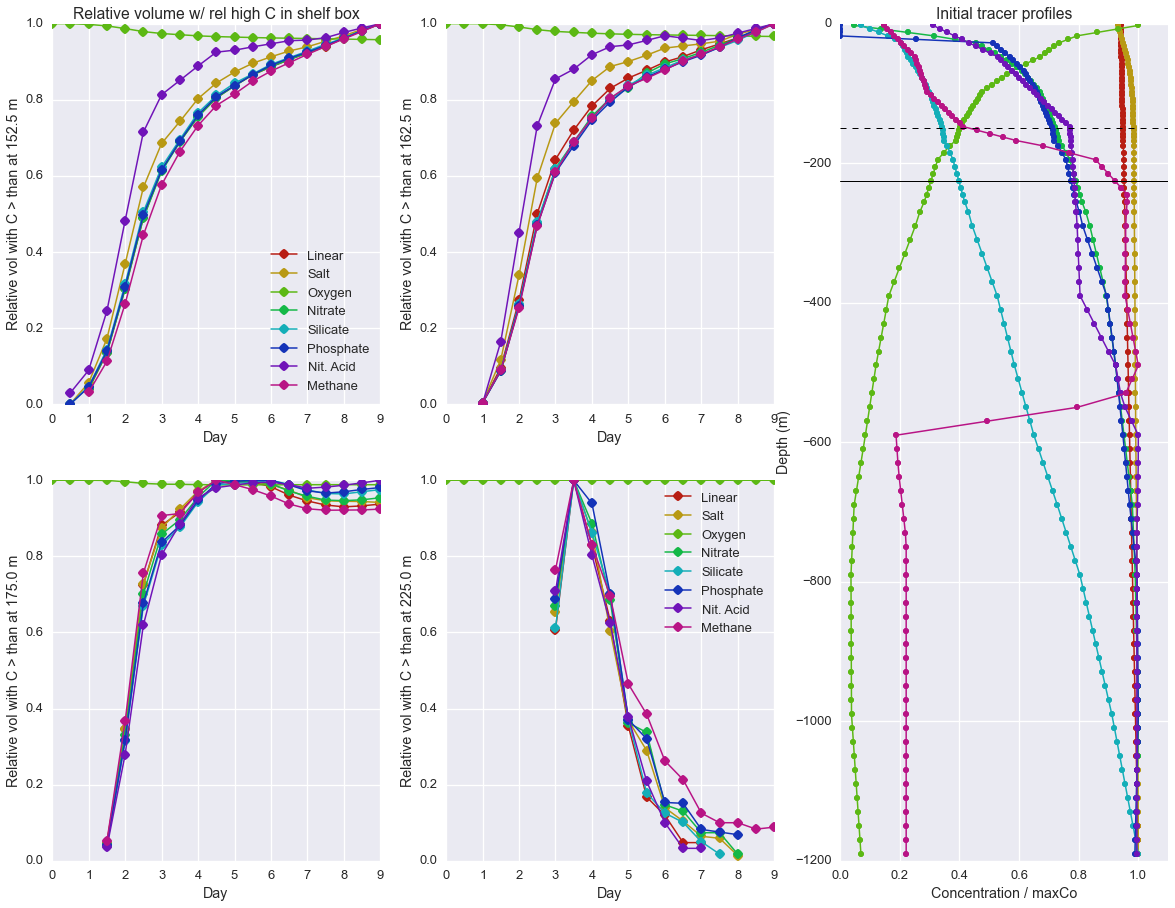

In [19]:
fig45=plt.figure(figsize=(20,15))
sns.set(context='talk', style='darkgrid', font='sans-serif', font_scale=1,rc={"lines.linewidth": 1.5})

times = np.arange(0,nt,1)

#with sns.color_palette('YlOrRd_r',8):
with sns.hls_palette(8, l=.4, s=.8):    
    ax1 = plt.subplot(2,3,1)

    line1 = ax1.plot(times/2.0, WatTr1/np.max(WatTr1),'o-',label='Linear')
    line2 = ax1.plot(times/2.0, WatTr2/np.max(WatTr2),'o-', label='Salt')
    line3 = ax1.plot(times/2.0, WatTr3/np.max(WatTr3),'o-', label='Oxygen')
    line4 = ax1.plot(times/2.0, WatTr4/np.max(WatTr4),'o-', label='Nitrate')
    line5 = ax1.plot(times/2.0, WatTr5/np.max(WatTr5),'o-', label='Silicate')
    line6 = ax1.plot(times/2.0, WatTr6/np.max(WatTr6),'o-', label='Phosphate')
    line7 = ax1.plot(times/2.0, WatTr7/np.max(WatTr7),'o-', label='Nit. Acid')
    line8 = ax1.plot(times/2.0, WatTr8/np.max(WatTr8),'o-', label='Methane')
    
    plt.title('Relative volume w/ rel high C in shelf box')
    plt.ylabel('Relative vol with C > than at 152.5 m')
    plt.xlabel('Day')

with sns.hls_palette(8, l=.4, s=.8):
    ax2 = plt.subplot(2,3,2)

    line1 = ax2.plot(times/2.0, WatTr1b/np.max(WatTr1b),'o-',label='Linear')
    line2 = ax2.plot(times/2.0, WatTr2b/np.max(WatTr2b),'o-', label='Salt')
    line3 = ax2.plot(times/2.0, WatTr3b/np.max(WatTr3b),'o-', label='Oxygen')
    line4 = ax2.plot(times/2.0, WatTr4b/np.max(WatTr4b),'o-', label='Nitrate')
    line5 = ax2.plot(times/2.0, WatTr5b/np.max(WatTr5b),'o-', label='Silicate')
    line6 = ax2.plot(times/2.0, WatTr6b/np.max(WatTr6b),'o-', label='Phosphate')
    line7 = ax2.plot(times/2.0, WatTr7b/np.max(WatTr7b),'o-', label='Nit. Acid')
    line8 = ax2.plot(times/2.0, WatTr8b/np.max(WatTr8b),'o-', label='Methane')
    
    #plt.title('Relative volume w/ rel high C in shelf box')
    plt.ylabel('Relative vol with C > than at 162.5 m')
    plt.xlabel('Day')
 
with sns.hls_palette(8, l=.4, s=.8):
    ax3 = plt.subplot(2,3,4)

    line1 = ax3.plot(times/2.0, WatTr1c/np.max(WatTr1c),'o-',label='Linear')
    line2 = ax3.plot(times/2.0, WatTr2c/np.max(WatTr2c),'o-', label='Salt')
    line3 = ax3.plot(times/2.0, WatTr3c/np.max(WatTr3c),'o-', label='Oxygen')
    line4 = ax3.plot(times/2.0, WatTr4c/np.max(WatTr4c),'o-', label='Nitrate')
    line5 = ax3.plot(times/2.0, WatTr5c/np.max(WatTr5c),'o-', label='Silicate')
    line6 = ax3.plot(times/2.0, WatTr6c/np.max(WatTr6c),'o-', label='Phosphate')
    line7 = ax3.plot(times/2.0, WatTr7c/np.max(WatTr7c),'o-', label='Nit. Acid')
    line8 = ax3.plot(times/2.0, WatTr8c/np.max(WatTr8c),'o-', label='Methane')
    
    #plt.title('Relative volume w/ rel high C in shelf box')
    plt.ylabel('Relative vol with C > than at 175.0 m')
    plt.xlabel('Day')
    
with sns.hls_palette(8, l=.4, s=.8):
    ax4 = plt.subplot(2,3,5)

    line1 = ax4.plot(times/2.0, WatTr1d/np.max(WatTr1d),'o-',label='Linear')
    line2 = ax4.plot(times/2.0, WatTr2d/np.max(WatTr2d),'o-', label='Salt')
    line3 = ax4.plot(times/2.0, WatTr3d/np.max(WatTr3d),'o-', label='Oxygen')
    line4 = ax4.plot(times/2.0, WatTr4d/np.max(WatTr4d),'o-', label='Nitrate')
    line5 = ax4.plot(times/2.0, WatTr5d/np.max(WatTr5d),'o-', label='Silicate')
    line6 = ax4.plot(times/2.0, WatTr6d/np.max(WatTr6d),'o-', label='Phosphate')
    line7 = ax4.plot(times/2.0, WatTr7d/np.max(WatTr7d),'o-', label='Nit. Acid')
    line8 = ax4.plot(times/2.0, WatTr8d/np.max(WatTr8d),'o-', label='Methane')
    
    #plt.title('Relative volume w/ rel high C in shelf box')
    plt.ylabel('Relative vol with C > than at 225.0 m')
    plt.xlabel('Day')

with sns.hls_palette(8, l=.4, s=.8):
    ax5 = plt.subplot(2,3,(3,6))
    
    line1 = ax5.plot(Tr1[0,:,50,180]/np.max(Tr1[0,:,50,180]),rc[:],'o-',markersize = 6, label='Linear')
    line2 = ax5.plot(Tr2[0,:,50,180]/np.max(Tr2[0,:,50,180]),rc[:],'o-',markersize = 6, label='Salt')
    line3 = ax5.plot(Tr3[0,:,50,180]/np.max(Tr3[0,:,50,180]),rc[:],'o-',markersize = 6, label='Oxygen')
    line4 = ax5.plot(Tr4[0,:,50,180]/np.max(Tr4[0,:,50,180]),rc[:],'o-',markersize = 6, label='Nitrate')
    line5 = ax5.plot(Tr5[0,:,50,180]/np.max(Tr5[0,:,50,180]),rc[:],'o-',markersize = 6, label='Silicate')
    line6 = ax5.plot(Tr6[0,:,50,180]/np.max(Tr6[0,:,50,180]),rc[:],'o-',markersize = 6, label='Phosphate')
    line7 = ax5.plot(Tr7[0,:,50,180]/np.max(Tr7[0,:,50,180]),rc[:],'o-',markersize = 6, label='Nit. Acid')
    line8 = ax5.plot(Tr8[0,:,50,180]/np.max(Tr8[0,:,50,180]),rc[:],'o-',markersize = 6, label='Methane')
    
     
    ax5.set_xlim(0,1.1)
    plt.title('Initial tracer profiles')
    plt.axhline(y=-150,linewidth=1, color='k', linestyle='--')
    plt.axhline(y=-225,linewidth=1, color='k', linestyle='-')
    
    plt.ylabel('Depth (m)')
    plt.xlabel('Concentration / maxCo')
    
    
#plt.tight_layout()
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, labels, loc=0)
   
#handles, labels = ax2.get_legend_handles_labels()
#ax2.legend(handles, labels,loc=0)

handles, labels = ax4.get_legend_handles_labels()
ax4.legend(handles, labels,loc=0)



#fig45.savefig('/ocean/kramosmu/Figures/WaterVolumeOverShelf/MassOverShelfIsoEffectTr1.eps', format='eps', dpi=1000, bbox_inches='tight')

        
        


The deepest water I could find on the shelf at some time during the simulation comes from 235 m for methane (rc[40]) and from 225 m for the other tracers (rc[39]). The max volume of high-concentration water seems to occur earlier in the simulation for higher (deeper) concentrations. Does that give a mixing/diffusion timescale? time of max will occur at different times for different concentration thresholds, most likely the higher the concentration the smaller the day of occurence. 


There is another timescale: It takes water initially at 225 m about 3 days to get to the shelf, and water initially at 175 m about 1.5 days and water at 165 m about 1 day ...


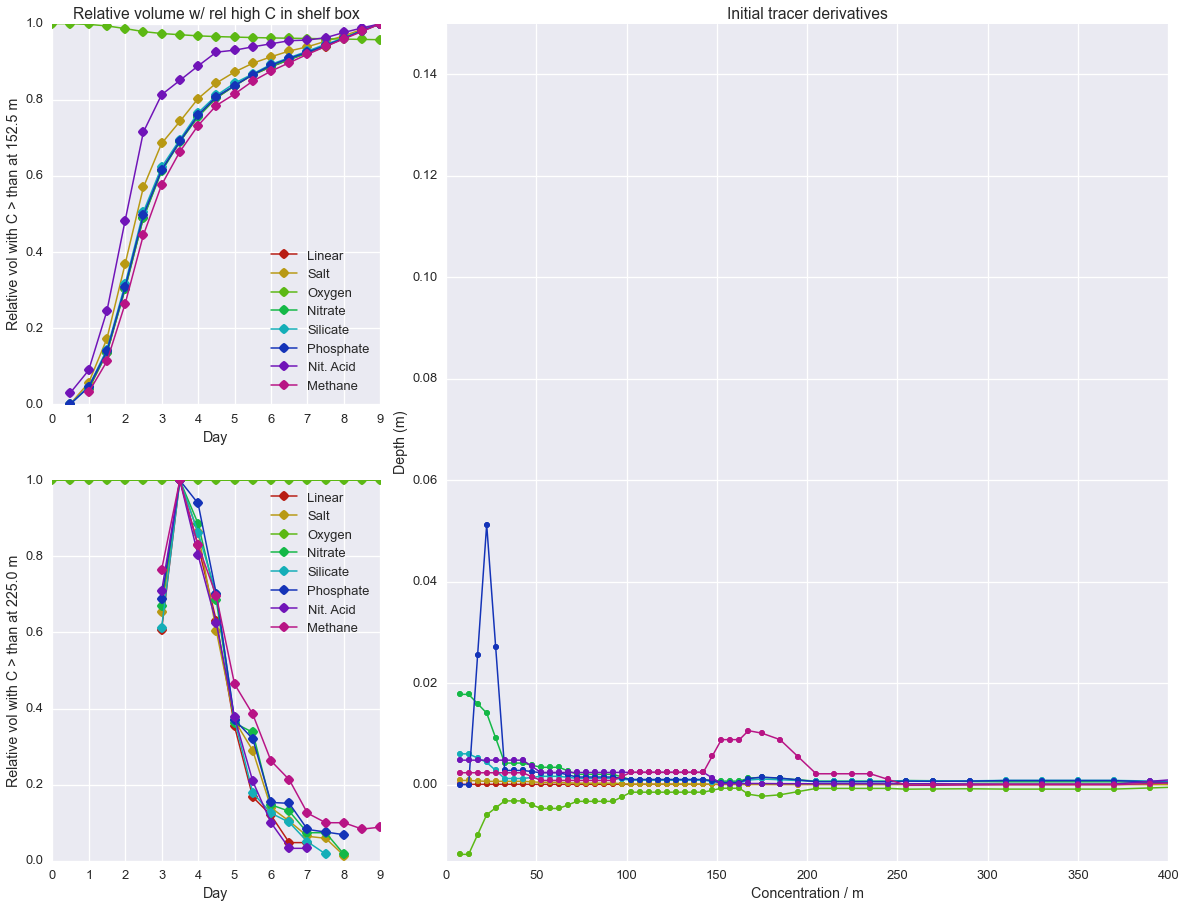

In [20]:
fig45=plt.figure(figsize=(20,15))
sns.set(context='talk', style='darkgrid', font='sans-serif', font_scale=1,rc={"lines.linewidth": 1.5})

times = np.arange(0,nt,1)

NormDerTr1 = ((Tr1[0,2:,50,180]-Tr1[0,:-2,50,180])/np.max(Tr1[0,:,50,180])) /((-rc[2:])-(-rc[:-2]))
NormDerTr2 = ((Tr2[0,2:,50,180]-Tr2[0,:-2,50,180])/np.max(Tr2[0,:,50,180])) /((-rc[2:])-(-rc[:-2]))
NormDerTr3 = ((Tr3[0,2:,50,180]-Tr3[0,:-2,50,180])/np.max(Tr3[0,:,50,180])) /((-rc[2:])-(-rc[:-2]))
NormDerTr4 = ((Tr4[0,2:,50,180]-Tr4[0,:-2,50,180])/np.max(Tr4[0,:,50,180])) /((-rc[2:])-(-rc[:-2]))
NormDerTr5 = ((Tr5[0,2:,50,180]-Tr5[0,:-2,50,180])/np.max(Tr5[0,:,50,180])) /((-rc[2:])-(-rc[:-2]))
NormDerTr6 = ((Tr6[0,2:,50,180]-Tr6[0,:-2,50,180])/np.max(Tr6[0,:,50,180])) /((-rc[2:])-(-rc[:-2]))
NormDerTr7 = ((Tr7[0,2:,50,180]-Tr7[0,:-2,50,180])/np.max(Tr7[0,:,50,180])) /((-rc[2:])-(-rc[:-2]))
NormDerTr8 = ((Tr8[0,2:,50,180]-Tr8[0,:-2,50,180])/np.max(Tr8[0,:,50,180])) /((-rc[2:])-(-rc[:-2]))



#with sns.color_palette('YlOrRd_r',8):
with sns.hls_palette(8, l=.4, s=.8):    
    #ax1 = plt.subplot(2,3,1)
    ax1 = plt.subplot2grid((2,3), (0,0))

    line1 = ax1.plot(times/2.0, WatTr1/np.max(WatTr1),'o-',label='Linear')
    line2 = ax1.plot(times/2.0, WatTr2/np.max(WatTr2),'o-', label='Salt')
    line3 = ax1.plot(times/2.0, WatTr3/np.max(WatTr3),'o-', label='Oxygen')
    line4 = ax1.plot(times/2.0, WatTr4/np.max(WatTr4),'o-', label='Nitrate')
    line5 = ax1.plot(times/2.0, WatTr5/np.max(WatTr5),'o-', label='Silicate')
    line6 = ax1.plot(times/2.0, WatTr6/np.max(WatTr6),'o-', label='Phosphate')
    line7 = ax1.plot(times/2.0, WatTr7/np.max(WatTr7),'o-', label='Nit. Acid')
    line8 = ax1.plot(times/2.0, WatTr8/np.max(WatTr8),'o-', label='Methane')
    
    plt.title('Relative volume w/ rel high C in shelf box')
    plt.ylabel('Relative vol with C > than at 152.5 m')
    plt.xlabel('Day')


with sns.hls_palette(8, l=.4, s=.8):
    #ax4 = plt.subplot(2,3,4)
    ax4 = plt.subplot2grid((2,3), (1,0))
    line1 = ax4.plot(times/2.0, WatTr1d/np.max(WatTr1d),'o-',label='Linear')
    line2 = ax4.plot(times/2.0, WatTr2d/np.max(WatTr2d),'o-', label='Salt')
    line3 = ax4.plot(times/2.0, WatTr3d/np.max(WatTr3d),'o-', label='Oxygen')
    line4 = ax4.plot(times/2.0, WatTr4d/np.max(WatTr4d),'o-', label='Nitrate')
    line5 = ax4.plot(times/2.0, WatTr5d/np.max(WatTr5d),'o-', label='Silicate')
    line6 = ax4.plot(times/2.0, WatTr6d/np.max(WatTr6d),'o-', label='Phosphate')
    line7 = ax4.plot(times/2.0, WatTr7d/np.max(WatTr7d),'o-', label='Nit. Acid')
    line8 = ax4.plot(times/2.0, WatTr8d/np.max(WatTr8d),'o-', label='Methane')
    
    #plt.title('Relative volume w/ rel high C in shelf box')
    plt.ylabel('Relative vol with C > than at 225.0 m')
    plt.xlabel('Day')

with sns.hls_palette(8, l=.4, s=.8):
    #ax5 = plt.subplot(2,3,(5,6))
    ax5 = plt.subplot2grid((2,3), (0,1), colspan=2,rowspan=2)
    
    line1 = ax5.plot(-rc[1:-1],NormDerTr1,'o-',markersize = 6, label='Linear')
    line2 = ax5.plot(-rc[1:-1],NormDerTr2,'o-',markersize = 6, label='Salt')
    line3 = ax5.plot(-rc[1:-1],NormDerTr3,'o-',markersize = 6, label='Oxygen')
    line4 = ax5.plot(-rc[1:-1],NormDerTr4,'o-',markersize = 6, label='Nitrate')
    line5 = ax5.plot(-rc[1:-1],NormDerTr5,'o-',markersize = 6, label='Silicate')
    line6 = ax5.plot(-rc[1:-1],NormDerTr6,'o-',markersize = 6, label='Phosphate')
    line7 = ax5.plot(-rc[1:-1],NormDerTr7,'o-',markersize = 6, label='Nit. Acid')
    line8 = ax5.plot(-rc[1:-1],NormDerTr8,'o-',markersize = 6, label='Methane')
    
     
    ax5.set_xlim(0,400)
    ax5.set_ylim(-0.015,0.15)
    
    plt.title('Initial tracer derivatives')
    #plt.axhline(y=-150,linewidth=1, color='k', linestyle='--')
    #plt.axhline(y=-225,linewidth=1, color='k', linestyle='-')
    
    plt.ylabel('Depth (m)')
    plt.xlabel('Concentration / m')
    
    
#plt.tight_layout()
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, labels, loc=0)
   
#handles, labels = ax2.get_legend_handles_labels()
#ax2.legend(handles, labels,loc=0)

handles, labels = ax4.get_legend_handles_labels()
ax4.legend(handles, labels,loc=0)



#fig45.savefig('/ocean/kramosmu/Figures/WaterVolumeOverShelf/MassOverShelfIsoEffectTr1.eps', format='eps', dpi=1000, bbox_inches='tight')

        
        


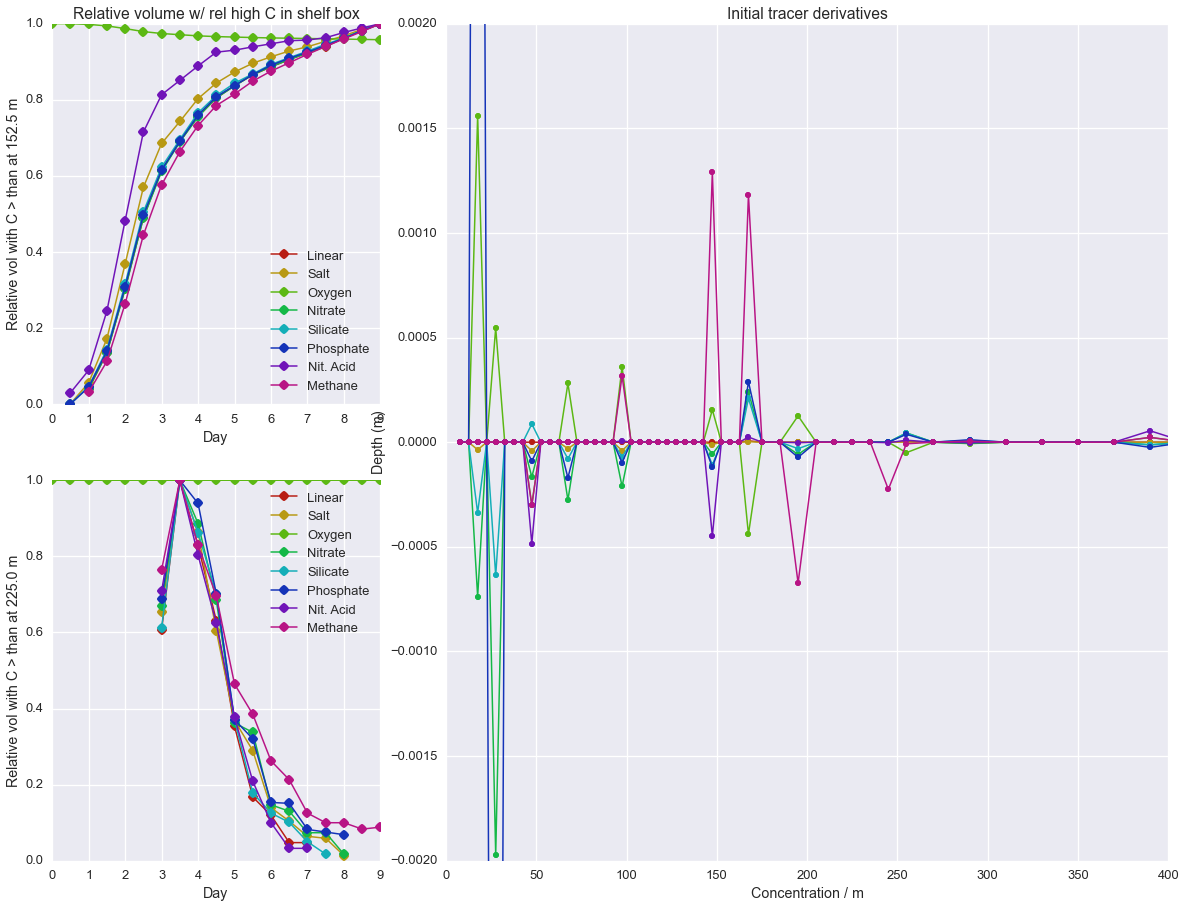

In [21]:
fig45=plt.figure(figsize=(20,15))
sns.set(context='talk', style='darkgrid', font='sans-serif', font_scale=1,rc={"lines.linewidth": 1.5})

times = np.arange(0,nt,1)

NormDer2Tr1 = ((Tr1[0,2:,50,180]-2.0*Tr1[0,1:-1,50,180]+Tr1[0,:-2,50,180])/np.max(Tr1[0,:,50,180]))/(((-rc[2:])-(-rc[1:-1]))*((-rc[1:-1])-(-rc[:-2])))
NormDer2Tr2 = ((Tr2[0,2:,50,180]-2.0*Tr2[0,1:-1,50,180]+Tr2[0,:-2,50,180])/np.max(Tr2[0,:,50,180]))/(((-rc[2:])-(-rc[1:-1]))*((-rc[1:-1])-(-rc[:-2])))
NormDer2Tr3 = ((Tr3[0,2:,50,180]-2.0*Tr3[0,1:-1,50,180]+Tr3[0,:-2,50,180])/np.max(Tr3[0,:,50,180]))/(((-rc[2:])-(-rc[1:-1]))*((-rc[1:-1])-(-rc[:-2])))
NormDer2Tr4 = ((Tr4[0,2:,50,180]-2.0*Tr4[0,1:-1,50,180]+Tr4[0,:-2,50,180])/np.max(Tr4[0,:,50,180]))/(((-rc[2:])-(-rc[1:-1]))*((-rc[1:-1])-(-rc[:-2])))
NormDer2Tr5 = ((Tr5[0,2:,50,180]-2.0*Tr5[0,1:-1,50,180]+Tr5[0,:-2,50,180])/np.max(Tr5[0,:,50,180]))/(((-rc[2:])-(-rc[1:-1]))*((-rc[1:-1])-(-rc[:-2])))
NormDer2Tr6 = ((Tr6[0,2:,50,180]-2.0*Tr6[0,1:-1,50,180]+Tr6[0,:-2,50,180])/np.max(Tr6[0,:,50,180]))/(((-rc[2:])-(-rc[1:-1]))*((-rc[1:-1])-(-rc[:-2])))
NormDer2Tr7 = ((Tr7[0,2:,50,180]-2.0*Tr7[0,1:-1,50,180]+Tr7[0,:-2,50,180])/np.max(Tr7[0,:,50,180]))/(((-rc[2:])-(-rc[1:-1]))*((-rc[1:-1])-(-rc[:-2])))
NormDer2Tr8 = ((Tr8[0,2:,50,180]-2.0*Tr8[0,1:-1,50,180]+Tr8[0,:-2,50,180])/np.max(Tr8[0,:,50,180]))/(((-rc[2:])-(-rc[1:-1]))*((-rc[1:-1])-(-rc[:-2])))



#with sns.color_palette('YlOrRd_r',8):
with sns.hls_palette(8, l=.4, s=.8):    
    #ax1 = plt.subplot(2,3,1)
    ax1 = plt.subplot2grid((2,3), (0,0))

    line1 = ax1.plot(times/2.0, WatTr1/np.max(WatTr1),'o-',label='Linear')
    line2 = ax1.plot(times/2.0, WatTr2/np.max(WatTr2),'o-', label='Salt')
    line3 = ax1.plot(times/2.0, WatTr3/np.max(WatTr3),'o-', label='Oxygen')
    line4 = ax1.plot(times/2.0, WatTr4/np.max(WatTr4),'o-', label='Nitrate')
    line5 = ax1.plot(times/2.0, WatTr5/np.max(WatTr5),'o-', label='Silicate')
    line6 = ax1.plot(times/2.0, WatTr6/np.max(WatTr6),'o-', label='Phosphate')
    line7 = ax1.plot(times/2.0, WatTr7/np.max(WatTr7),'o-', label='Nit. Acid')
    line8 = ax1.plot(times/2.0, WatTr8/np.max(WatTr8),'o-', label='Methane')
    
    plt.title('Relative volume w/ rel high C in shelf box')
    plt.ylabel('Relative vol with C > than at 152.5 m')
    plt.xlabel('Day')


with sns.hls_palette(8, l=.4, s=.8):
    #ax4 = plt.subplot(2,3,4)
    ax4 = plt.subplot2grid((2,3), (1,0))
    line1 = ax4.plot(times/2.0, WatTr1d/np.max(WatTr1d),'o-',label='Linear')
    line2 = ax4.plot(times/2.0, WatTr2d/np.max(WatTr2d),'o-', label='Salt')
    line3 = ax4.plot(times/2.0, WatTr3d/np.max(WatTr3d),'o-', label='Oxygen')
    line4 = ax4.plot(times/2.0, WatTr4d/np.max(WatTr4d),'o-', label='Nitrate')
    line5 = ax4.plot(times/2.0, WatTr5d/np.max(WatTr5d),'o-', label='Silicate')
    line6 = ax4.plot(times/2.0, WatTr6d/np.max(WatTr6d),'o-', label='Phosphate')
    line7 = ax4.plot(times/2.0, WatTr7d/np.max(WatTr7d),'o-', label='Nit. Acid')
    line8 = ax4.plot(times/2.0, WatTr8d/np.max(WatTr8d),'o-', label='Methane')
    
    #plt.title('Relative volume w/ rel high C in shelf box')
    plt.ylabel('Relative vol with C > than at 225.0 m')
    plt.xlabel('Day')

with sns.hls_palette(8, l=.4, s=.8):
    #ax5 = plt.subplot(2,3,(5,6))
    ax5 = plt.subplot2grid((2,3), (0,1), colspan=2,rowspan=2)
    
    line1 = ax5.plot(-rc[1:-1],NormDer2Tr1,'o-',markersize = 6, label='Linear')
    line2 = ax5.plot(-rc[1:-1],NormDer2Tr2,'o-',markersize = 6, label='Salt')
    line3 = ax5.plot(-rc[1:-1],NormDer2Tr3,'o-',markersize = 6, label='Oxygen')
    line4 = ax5.plot(-rc[1:-1],NormDer2Tr4,'o-',markersize = 6, label='Nitrate')
    line5 = ax5.plot(-rc[1:-1],NormDer2Tr5,'o-',markersize = 6, label='Silicate')
    line6 = ax5.plot(-rc[1:-1],NormDer2Tr6,'o-',markersize = 6, label='Phosphate')
    line7 = ax5.plot(-rc[1:-1],NormDer2Tr7,'o-',markersize = 6, label='Nit. Acid')
    line8 = ax5.plot(-rc[1:-1],NormDer2Tr8,'o-',markersize = 6, label='Methane')
    
     
    ax5.set_xlim(0,400)
    ax5.set_ylim(-0.002,0.002)
    
    plt.title('Initial tracer derivatives')
    #plt.axhline(y=-150,linewidth=1, color='k', linestyle='--')
    #plt.axhline(y=-225,linewidth=1, color='k', linestyle='-')
    
    plt.ylabel('Depth (m)')
    plt.xlabel('Concentration / m')
    
    
#plt.tight_layout()
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, labels, loc=0)
   
#handles, labels = ax2.get_legend_handles_labels()
#ax2.legend(handles, labels,loc=0)

handles, labels = ax4.get_legend_handles_labels()
ax4.legend(handles, labels,loc=0)



#fig45.savefig('/ocean/kramosmu/Figures/WaterVolumeOverShelf/MassOverShelfIsoEffectTr1.eps', format='eps', dpi=1000, bbox_inches='tight')

        
        


The second derivative looks too noisy. Let's look at average derivative under shelfbreak over average derivative over shelf break

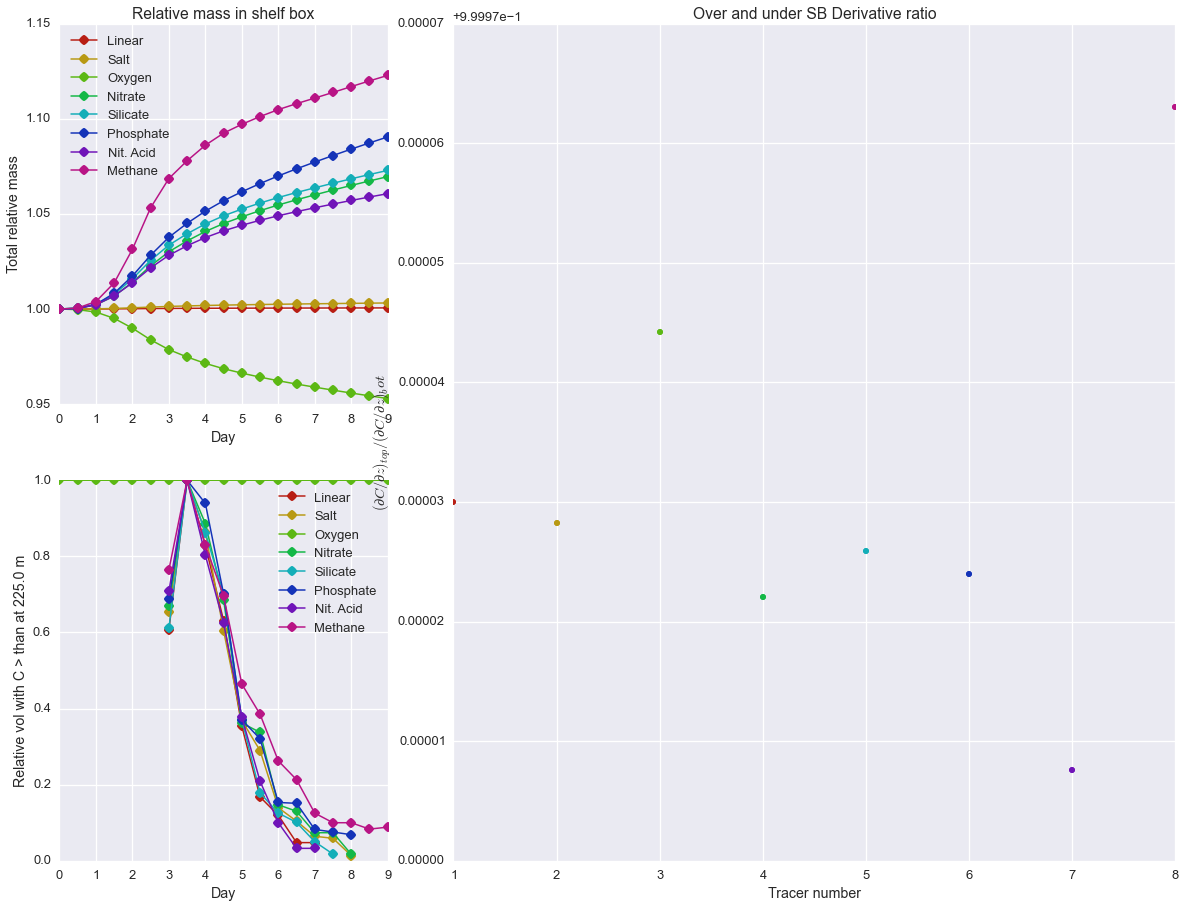

In [22]:
fig45=plt.figure(figsize=(20,15))
sns.set(context='talk', style='darkgrid', font='sans-serif', font_scale=1,rc={"lines.linewidth": 1.5})

times = np.arange(0,nt,1)

NormDerTr1 = ((Tr1[0,2:,50,180]-Tr1[0,:-2,50,180])/np.max(Tr1[0,:,50,180])) /((-rc[2:])-(-rc[:-2]))
NormDerTr2 = ((Tr2[0,2:,50,180]-Tr2[0,:-2,50,180])/np.max(Tr2[0,:,50,180])) /((-rc[2:])-(-rc[:-2]))
NormDerTr3 = ((Tr3[0,2:,50,180]-Tr3[0,:-2,50,180])/np.max(Tr3[0,:,50,180])) /((-rc[2:])-(-rc[:-2]))
NormDerTr4 = ((Tr4[0,2:,50,180]-Tr4[0,:-2,50,180])/np.max(Tr4[0,:,50,180])) /((-rc[2:])-(-rc[:-2]))
NormDerTr5 = ((Tr5[0,2:,50,180]-Tr5[0,:-2,50,180])/np.max(Tr5[0,:,50,180])) /((-rc[2:])-(-rc[:-2]))
NormDerTr6 = ((Tr6[0,2:,50,180]-Tr6[0,:-2,50,180])/np.max(Tr6[0,:,50,180])) /((-rc[2:])-(-rc[:-2]))
NormDerTr7 = ((Tr7[0,2:,50,180]-Tr7[0,:-2,50,180])/np.max(Tr7[0,:,50,180])) /((-rc[2:])-(-rc[:-2]))
NormDerTr8 = ((Tr8[0,2:,50,180]-Tr8[0,:-2,50,180])/np.max(Tr8[0,:,50,180])) /((-rc[2:])-(-rc[:-2]))


#with sns.color_palette('YlOrRd_r',8):
with sns.hls_palette(8, l=.4, s=.8):    
    #ax1 = plt.subplot(2,3,1)
    ax1 = plt.subplot2grid((2,3), (0,0))

    line1 = ax1.plot(times/2.0, TrMassTr1/TrMassTr1[0],'o-', label='Linear')
    line2 = ax1.plot(times/2.0, TrMassTr2/TrMassTr2[0],'o-', label='Salt')
    line3 = ax1.plot(times/2.0, TrMassTr3/TrMassTr3[0],'o-', label='Oxygen')
    line4 = ax1.plot(times/2.0, TrMassTr4/TrMassTr4[0],'o-', label='Nitrate')
    line5 = ax1.plot(times/2.0, TrMassTr5/TrMassTr5[0],'o-', label='Silicate')
    line6 = ax1.plot(times/2.0, TrMassTr6/TrMassTr6[0],'o-', label='Phosphate')
    line7 = ax1.plot(times/2.0, TrMassTr7/TrMassTr7[0],'o-', label='Nit. Acid')
    line8 = ax1.plot(times/2.0, TrMassTr8/TrMassTr8[0],'o-', label='Methane')

    plt.title('Relative mass in shelf box')
    plt.ylabel('Total relative mass')
    plt.xlabel('Day')


with sns.hls_palette(8, l=.4, s=.8):
    #ax4 = plt.subplot(2,3,4)
    ax4 = plt.subplot2grid((2,3), (1,0))
    line1 = ax4.plot(times/2.0, WatTr1d/np.max(WatTr1d),'o-',label='Linear')
    line2 = ax4.plot(times/2.0, WatTr2d/np.max(WatTr2d),'o-', label='Salt')
    line3 = ax4.plot(times/2.0, WatTr3d/np.max(WatTr3d),'o-', label='Oxygen')
    line4 = ax4.plot(times/2.0, WatTr4d/np.max(WatTr4d),'o-', label='Nitrate')
    line5 = ax4.plot(times/2.0, WatTr5d/np.max(WatTr5d),'o-', label='Silicate')
    line6 = ax4.plot(times/2.0, WatTr6d/np.max(WatTr6d),'o-', label='Phosphate')
    line7 = ax4.plot(times/2.0, WatTr7d/np.max(WatTr7d),'o-', label='Nit. Acid')
    line8 = ax4.plot(times/2.0, WatTr8d/np.max(WatTr8d),'o-', label='Methane')
    
    #plt.title('Relative volume w/ rel high C in shelf box')
    plt.ylabel('Relative vol with C > than at 225.0 m')
    plt.xlabel('Day')

with sns.hls_palette(8, l=.4, s=.8):
    #ax5 = plt.subplot(2,3,(5,6))
    ax5 = plt.subplot2grid((2,3), (0,1), colspan=2,rowspan=2)
    
    line1 = ax5.plot(1,1.-(np.mean(NormDerTr1[10:29])-(np.mean(NormDerTr1[29:43])))/(np.mean(rc[10:29])-np.mean(rc[29:43])),'o',markersize = 6, label='Linear')
    line2 = ax5.plot(2,1.-(np.mean(NormDerTr2[10:29])-(np.mean(NormDerTr2[29:43])))/(np.mean(rc[10:29])-np.mean(rc[29:43])),'o',markersize = 6, label='Salt')
    line3 = ax5.plot(3,1.-(np.mean(NormDerTr3[10:29])-(np.mean(NormDerTr3[29:43])))/(np.mean(rc[10:29])-np.mean(rc[29:43])),'o',markersize = 6, label='Oxygen')
    line4 = ax5.plot(4,1.-(np.mean(NormDerTr4[10:29])-(np.mean(NormDerTr4[29:43])))/(np.mean(rc[10:29])-np.mean(rc[29:43])),'o',markersize = 6, label='Nitrate')
    line5 = ax5.plot(5,1.-(np.mean(NormDerTr5[10:29])-(np.mean(NormDerTr5[29:43])))/(np.mean(rc[10:29])-np.mean(rc[29:43])),'o',markersize = 6, label='Silicate')
    line6 = ax5.plot(6,1.-(np.mean(NormDerTr6[10:29])-(np.mean(NormDerTr6[29:43])))/(np.mean(rc[10:29])-np.mean(rc[29:43])),'o',markersize = 6, label='Phosphate')
    line7 = ax5.plot(7,1.-(np.mean(NormDerTr7[10:29])-(np.mean(NormDerTr7[29:43])))/(np.mean(rc[10:29])-np.mean(rc[29:43])),'o',markersize = 6, label='Nit. Acid')
    line8 = ax5.plot(8,1.-(np.mean(NormDerTr8[10:29])-(np.mean(NormDerTr8[29:43])))/(np.mean(rc[10:29])-np.mean(rc[29:43])),'o',markersize = 6, label='Methane')
    
     
    #ax5.set_xlim(0,400)
    #ax5.set_ylim(-0.002,0.002)
    
    plt.title('Over and under SB Derivative ratio')
    #plt.axhline(y=-150,linewidth=1, color='k', linestyle='--')
    #plt.axhline(y=-225,linewidth=1, color='k', linestyle='-')
    
    plt.ylabel('$(\partial{C}/\partial{z})_{top}/(\partial{C}/\partial{z})_bot$')
    plt.xlabel('Tracer number')
    
    
#plt.tight_layout()
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, labels, loc=0)
   
#handles, labels = ax2.get_legend_handles_labels()
#ax2.legend(handles, labels,loc=0)

handles, labels = ax4.get_legend_handles_labels()
ax4.legend(handles, labels,loc=0)



#fig45.savefig('/ocean/kramosmu/Figures/WaterVolumeOverShelf/MassOverShelfIsoEffectTr1.eps', format='eps', dpi=1000, bbox_inches='tight')

        
        


In [23]:
Tr1NoC =np.array([8131629878608714.0, 8131643443553263.0, 8131751186617983.0,
         8132042805070907.0, 8132507105363251.0, 8133098132763418.0,
         8133671582473557.0, 8134122939822958.0, 8134479960862460.0,
         8134770105007401.0, 8135013064283614.0, 8135222899559668.0,
         8135409192778357.0, 8135578534183246.0, 8135735548421446.0,
         8135883401476764.0, 8136024320996562.0, 8136159871970588.0,
         8136291153233666.0])
Tr2NoC =np.array([8343110606829764.0,8343212609729107.0,8343754415771154.0,
         8345284995236342.0,8347722619312930.0,8350830828539612.0,
         8353892443449054.0,8356384871288022.0,8358436306192016.0,
         8360164273206096.0,8361657149239941.0,8362980652970516.0,
         8364179066383490.0,8365283125476920.0,8366314930139546.0,
         8367289900420714.0,8368219132469768.0,8369110579804339.0,
         8369970104772490.0])
Tr3NoC =np.array([4.688628930045056e+16, 4.687506492597015e+16, 4.6831133930040424e+16,
         4.670477040270595e+16, 4.650279704673098e+16, 4.624493187012891e+16,
         4.599098225044632e+16, 4.578624516734864e+16, 4.561999835567534e+16,
         4.548168203207398e+16, 4.53634604713679e+16 ,4.5259579879751896e+16,
         4.516613005890283e+16, 4.508040264983226e+16, 4.500047678603494e+16,
         4.49250240234937e+16, 4.485309829301397e+16, 4.478402811048669e+16,
         4.471732671636612e+16])
Tr4NoC =np.array([4915238577054636.0,4917385851904468.0,4923481118794599.0,
         4942161839126024.0,4972566567807012.0,5011721836037820.0,
         5050576362661793.0,5082161934297893.0,5108107263007338.0,
         5129973298641865.0,5148911041504198.0,5165769181660996.0,
         5181112769502430.0,5195328234327018.0,5208688999953632.0,
         5221381831938792.0,5233538554458864.0,5245252149451364.0,
         5256590057708014.0])
Tr5NoC =np.array([7086604092585972.0,7089261414019234.0,7099706267746542.0,
         7129793539370537.0,7177764415001788.0,7238778457612076.0,
         7298608007826654.0,7346564353340818.0,7385309018106226.0,
         7417436787323170.0,7444843395126364.0,7468908701719414.0,
         7490565177166184.0,7510454383739015.0,7529028066877312.0,
         7546596095831592.0,7563377231244450.0,7579525231847034.0,
         7595150391195142.0])
Tr6NoC =np.array([292325140709075.25, 292350462906673.25, 292854397927821.1, 294283110753041.4,
         296573064637716.4, 299537570383282.06, 302494657834014.9, 304912620811635.1,
         306914648168280.1, 308617454308181.4, 310106892121278.2, 311446396491937.1,
         312676896163022.0,313825870783272.25, 314912874539061.4, 315951161511143.06,
         316949977006043.4, 317915746492119.0,318853045135098.5])
Tr7NoC =np.array([4356959908372676.0,4357862746557739.0,4363982671540229.0,
         4380650554667537.0,4406598806533396.0,4438924695336555.5,
         4470022129875683.5, 4494733455906235.0,4514613320066728.0,
         4531039974332056.0,4545006390964596.0,4557230441539752.0,
         4568197032580322.0,4578240510406644.0,4587597091097252.0,
         4596429726403736.0,4604853787425190.0,4612950168482986.0,
         4620777097532127.0])
Tr8NoC =np.array([2416117379460651.0,2416772136933131.0,2421529615122805.0,
         2435151768800695.0,2459309058696459.0,2492789293760246.0,
         2526514635102170.5, 2552567445586157.0,2572456067980318.0,
         2588128811644611.5, 2600928421988396.0,2611784361212620.0,
         2621322627532895.5, 2629964536767924.0,2637995858980977.5,
         2645607092910112.0,2652928340676250.0,2660048250629558.0,
         2667025749808153.0])

In [24]:
WatNoCTr1=np.array([0.0,0.0,0.0,157951298.58252147,1122711263.4200535,2288641645.0895834,
           3401203832.733767,4421941541.833515,5015899067.988339,5532803460.66979 ,
           5743982555.2475395,6103596038.603717,6419168412.482798,6707540739.473951,
           6808797947.47673,7026749674.823505,7230693327.951454,7406356709.928196,
           7521299534.972351])
WatNoCTr2=np.array([0.0,0.0,0.0,289481452.6234512,1147187551.3014512,2159294803.462012,
           3040975179.307279,3813127652.000657,4169380501.6821365,4690801869.650136,
           4964554888.256971,5173720318.582285,5297922756.896402,5418540192.014305,
           5589692931.359404,5702329443.459753,5849868362.951458,5986211131.7698555,
           6243998190.940744])
WatNoCTr3=np.array([253568477823.74634,253568477823.74634,253568477823.74634,253305432275.5772,
           252428171781.65866,251338624371.28564,250190962258.73956,249234710272.3564,
           248783143919.91998,248217385903.67603,247914784994.0296,247768868163.5589,
           247383827952.0891,247157484184.6111,246928201952.87085,246735951188.86786,
           246554226982.07202,246398133049.8515,246204839813.38074])
WatNoCTr4=np.array([0.0,0.0,0.0,224902322.11420524,1126937509.4667895,2258981588.9591074,
           3399975332.0896206,4382959221.984196,4964369475.636879,5469061322.033877,
           5703859703.423473,5994635615.969704,6308415637.110091,6620492239.404415,
           6761441356.876297,6983150063.900356,7123745276.353327,7359955653.738209,
           7485219769.454126])
WatNoCTr5=np.array([0.0,0.0,0.0,280043532.29148304,1149336653.7252305,2171833158.1160946,
           3279576082.5119433,4186046567.5286674,4594036871.40917,5203692273.398184,
           5426593947.516133,5683533479.240267,5868544001.267738,6192132344.408754,
           6320789758.881653,6552837744.978577,6717916109.767679,6972290010.899959,
           7075045596.085678])
WatNoCTr6=np.array([0.0,0.0,0.0,274588858.0487083,1147913082.5315304,2211778742.9472475,
           3350616530.7028656,4247381885.5756054,4660770974.841955,5280668654.161387,
           5598324476.096265,5739394813.895764,6068245287.358498,6269045970.481881,
           6527716368.922382,6696730118.080166,6923125201.198071,7058475407.633673,
           7236741536.959208])
WatNoCTr7=np.array([0.0,0.0,0.0,291827266.9190301,958816597.7982149,1908755801.3733392,
           2672960989.8432856,3012577980.536555,3502792071.6276255,3804396572.6634684,
           3950746837.181878,4146603949.3418207,4291868048.3185225,4424868511.597172,
           4537027665.686662,4621850062.718874,4737736045.535311,4827411076.988422,
           4901387545.473091])
WatNoCTr8=np.array([0.0,0.0,0.0,157951298.58252147,1127513869.9161,2481514552.0465364,
           4031595266.700057,4969231387.4270525,5853975444.086581,6406578901.559263,
           6956138385.703936,7340571794.872347,7612276858.8629265,7755662101.375096,
           8108034205.864901,8498616435.838461,8822743710.228748,9005173202.41588,
           9227065066.305937])


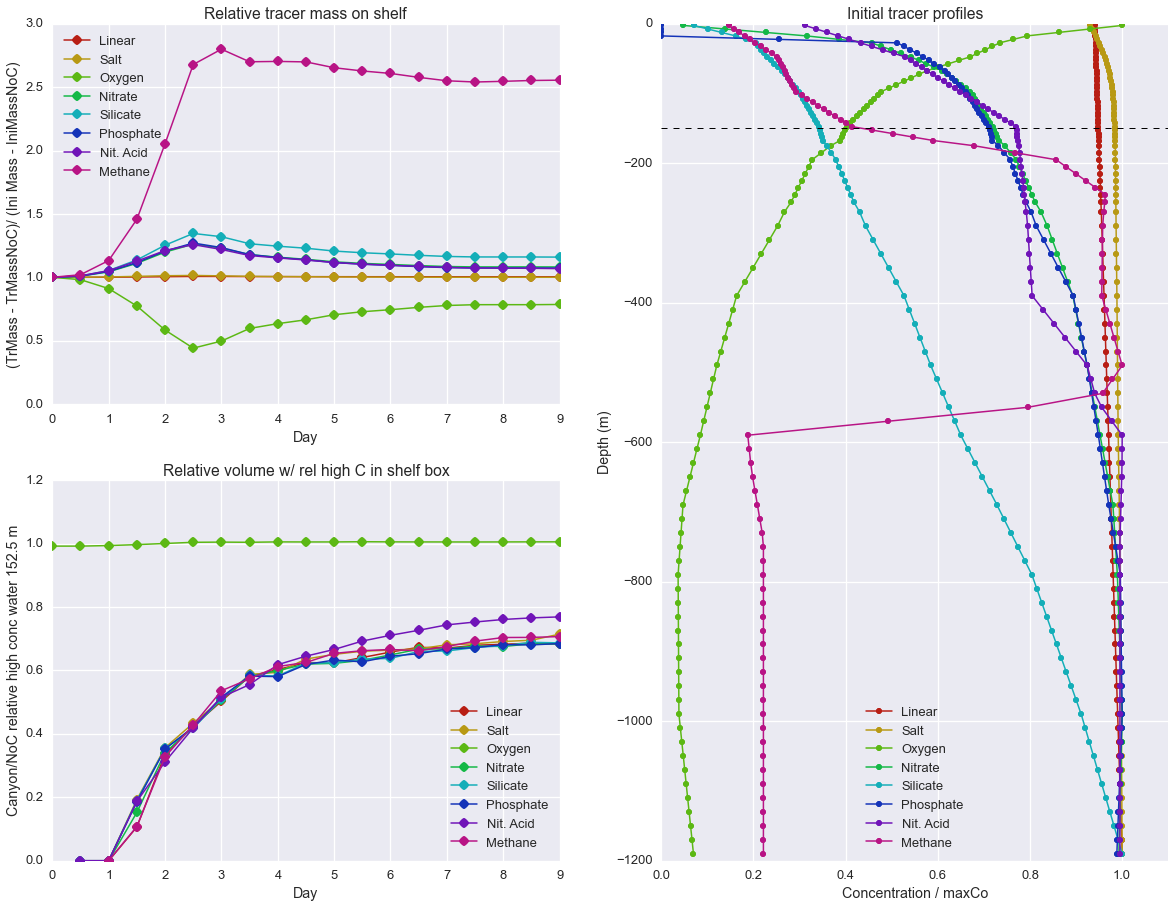

In [25]:
fig45=plt.figure(figsize=(20,15))
sns.set(context='talk', style='darkgrid', font='sans-serif', font_scale=1,rc={"lines.linewidth": 1.5})

times = np.arange(0,nt,1)

#with sns.color_palette('YlOrRd_r',8):
with sns.hls_palette(8, l=.4, s=.8):    
    ax1 = plt.subplot(2,2,1)

    line1 = ax1.plot(times/2.0, (TrMassTr1-Tr1NoC)/(TrMassTr1[0] -Tr1NoC[0]),'o-', label='Linear')
    line2 = ax1.plot(times/2.0, (TrMassTr2-Tr2NoC)/(TrMassTr2[0]-Tr2NoC[0]),'o-', label='Salt')
    line3 = ax1.plot(times/2.0, (TrMassTr3-Tr3NoC)/(TrMassTr3[0]-Tr3NoC[0]),'o-', label='Oxygen')
    line4 = ax1.plot(times/2.0, (TrMassTr4-Tr4NoC)/(TrMassTr4[0]-Tr4NoC[0]),'o-', label='Nitrate')
    line5 = ax1.plot(times/2.0, (TrMassTr5-Tr5NoC)/(TrMassTr5[0]-Tr5NoC[0]),'o-', label='Silicate')
    line6 = ax1.plot(times/2.0, (TrMassTr6-Tr6NoC)/(TrMassTr6[0]-Tr6NoC[0]),'o-', label='Phosphate')
    line7 = ax1.plot(times/2.0, (TrMassTr7-Tr7NoC)/(TrMassTr7[0]-Tr7NoC[0]),'o-', label='Nit. Acid')
    line8 = ax1.plot(times/2.0, (TrMassTr8-Tr8NoC)/(TrMassTr8[0]-Tr8NoC[0]),'o-', label='Methane')

    plt.ylabel('(TrMass - TrMassNoC)/ (Ini Mass - IniMassNoC) ')
    plt.xlabel('Day')
    plt.title('Relative tracer mass on shelf')
with sns.hls_palette(8, l=.4, s=.8):
    ax2 = plt.subplot(2,2,3)

    line1 = ax2.plot(times/2.0, WatNoCTr1/WatTr1,'o-',label='Linear')
    line2 = ax2.plot(times/2.0, WatNoCTr2/WatTr2,'o-', label='Salt')
    line3 = ax2.plot(times/2.0, WatNoCTr3/WatTr3,'o-', label='Oxygen')
    line4 = ax2.plot(times/2.0, WatNoCTr4/WatTr4,'o-', label='Nitrate')
    line5 = ax2.plot(times/2.0, WatNoCTr5/WatTr5,'o-', label='Silicate')
    line6 = ax2.plot(times/2.0, WatNoCTr6/WatTr6,'o-', label='Phosphate')
    line7 = ax2.plot(times/2.0, WatNoCTr7/WatTr7,'o-', label='Nit. Acid')
    line8 = ax2.plot(times/2.0, WatNoCTr8/WatTr8,'o-', label='Methane')
    
    plt.title('Relative volume w/ rel high C in shelf box')
    plt.ylabel('Canyon/NoC relative high conc water 152.5 m')
    plt.xlabel('Day')
 
with sns.hls_palette(8, l=.4, s=.8):
    ax3 = plt.subplot(2,2,(2,4))

    line1 = ax3.plot(Tr1[0,:,50,180]/np.max(Tr1[0,:,50,180]),rc[:],'o-',markersize = 6, label='Linear')
    line2 = ax3.plot(Tr2[0,:,50,180]/np.max(Tr2[0,:,50,180]),rc[:],'o-',markersize = 6, label='Salt')
    line3 = ax3.plot(Tr3[0,:,50,180]/np.max(Tr3[0,:,50,180]),rc[:],'o-',markersize = 6, label='Oxygen')
    line4 = ax3.plot(Tr4[0,:,50,180]/np.max(Tr4[0,:,50,180]),rc[:],'o-',markersize = 6, label='Nitrate')
    line5 = ax3.plot(Tr5[0,:,50,180]/np.max(Tr5[0,:,50,180]),rc[:],'o-',markersize = 6, label='Silicate')
    line6 = ax3.plot(Tr6[0,:,50,180]/np.max(Tr6[0,:,50,180]),rc[:],'o-',markersize = 6, label='Phosphate')
    line7 = ax3.plot(Tr7[0,:,50,180]/np.max(Tr7[0,:,50,180]),rc[:],'o-',markersize = 6, label='Nit. Acid')
    line8 = ax3.plot(Tr8[0,:,50,180]/np.max(Tr8[0,:,50,180]),rc[:],'o-',markersize = 6, label='Methane')
    
    ax3.set_xlim(0,1.1)
    plt.title('Initial tracer profiles')
    plt.axhline(y=-150,linewidth=1, color='k', linestyle='--')
    plt.ylabel('Depth (m)')
    plt.xlabel('Concentration / maxCo')
 
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, labels, loc=0)
   
handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles, labels,loc=0)

handles, labels = ax3.get_legend_handles_labels()
ax3.legend(handles, labels,loc=0)



#fig45.savefig('/ocean/kramosmu/Figures/WaterVolumeOverShelf/MassOverShelfIsoEffectTr1.eps', format='eps', dpi=1000, bbox_inches='tight')

        
        

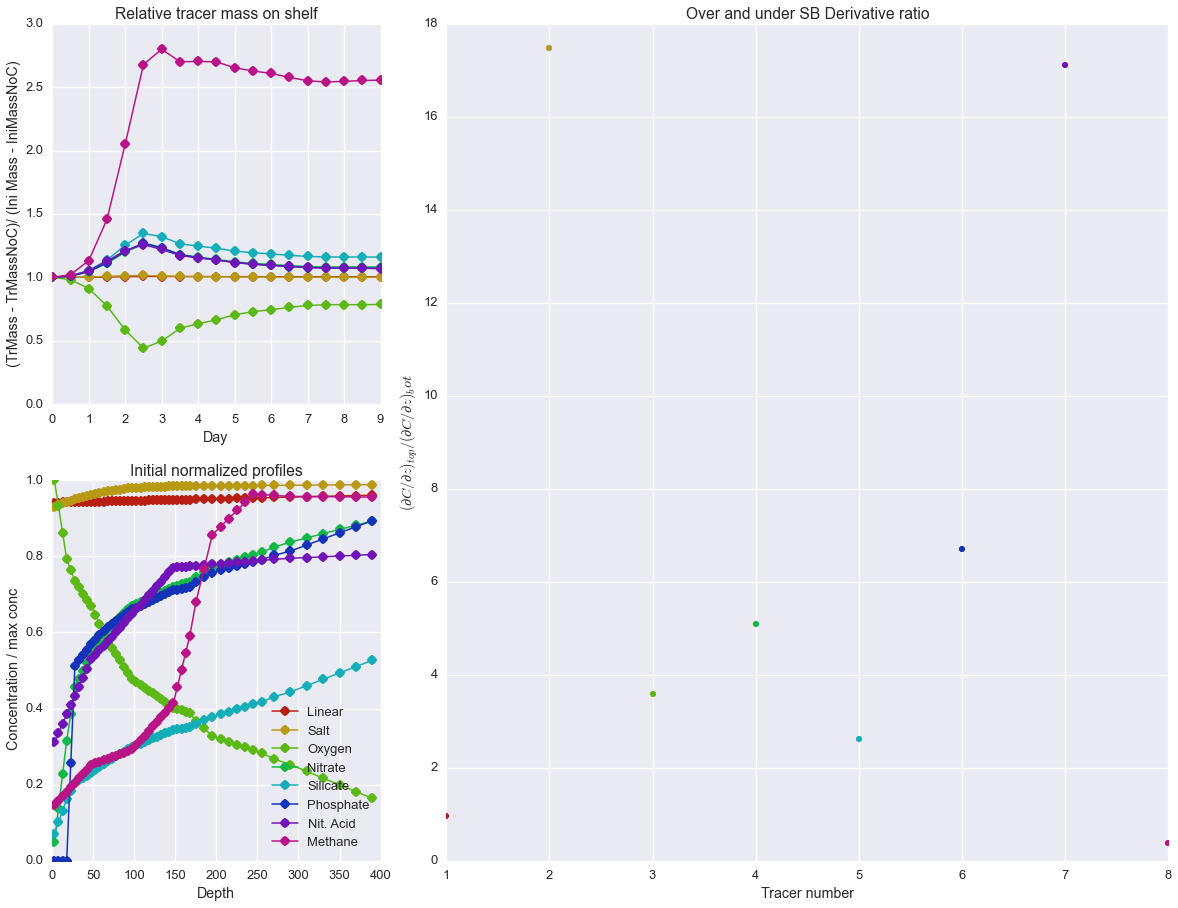

In [26]:
fig45=plt.figure(figsize=(20,15))
sns.set(context='talk', style='darkgrid', font='sans-serif', font_scale=1,rc={"lines.linewidth": 1.5})

times = np.arange(0,nt,1)

NormDerTr1 = ((Tr1[0,2:,50,180]-Tr1[0,:-2,50,180])/np.max(Tr1[0,:,50,180])) /((-rc[2:])-(-rc[:-2]))
NormDerTr2 = ((Tr2[0,2:,50,180]-Tr2[0,:-2,50,180])/np.max(Tr2[0,:,50,180])) /((-rc[2:])-(-rc[:-2]))
NormDerTr3 = ((Tr3[0,2:,50,180]-Tr3[0,:-2,50,180])/np.max(Tr3[0,:,50,180])) /((-rc[2:])-(-rc[:-2]))
NormDerTr4 = ((Tr4[0,2:,50,180]-Tr4[0,:-2,50,180])/np.max(Tr4[0,:,50,180])) /((-rc[2:])-(-rc[:-2]))
NormDerTr5 = ((Tr5[0,2:,50,180]-Tr5[0,:-2,50,180])/np.max(Tr5[0,:,50,180])) /((-rc[2:])-(-rc[:-2]))
NormDerTr6 = ((Tr6[0,2:,50,180]-Tr6[0,:-2,50,180])/np.max(Tr6[0,:,50,180])) /((-rc[2:])-(-rc[:-2]))
NormDerTr7 = ((Tr7[0,2:,50,180]-Tr7[0,:-2,50,180])/np.max(Tr7[0,:,50,180])) /((-rc[2:])-(-rc[:-2]))
NormDerTr8 = ((Tr8[0,2:,50,180]-Tr8[0,:-2,50,180])/np.max(Tr8[0,:,50,180])) /((-rc[2:])-(-rc[:-2]))


#with sns.color_palette('YlOrRd_r',8):
with sns.hls_palette(8, l=.4, s=.8):    
    #ax1 = plt.subplot(2,3,1)
    ax1 = plt.subplot2grid((2,3), (0,0), colspan=1,rowspan=1)
    
    line1 = ax1.plot(times/2.0, (TrMassTr1-Tr1NoC)/(TrMassTr1[0] -Tr1NoC[0]),'o-', label='Linear')
    line2 = ax1.plot(times/2.0, (TrMassTr2-Tr2NoC)/(TrMassTr2[0]-Tr2NoC[0]),'o-', label='Salt')
    line3 = ax1.plot(times/2.0, (TrMassTr3-Tr3NoC)/(TrMassTr3[0]-Tr3NoC[0]),'o-', label='Oxygen')
    line4 = ax1.plot(times/2.0, (TrMassTr4-Tr4NoC)/(TrMassTr4[0]-Tr4NoC[0]),'o-', label='Nitrate')
    line5 = ax1.plot(times/2.0, (TrMassTr5-Tr5NoC)/(TrMassTr5[0]-Tr5NoC[0]),'o-', label='Silicate')
    line6 = ax1.plot(times/2.0, (TrMassTr6-Tr6NoC)/(TrMassTr6[0]-Tr6NoC[0]),'o-', label='Phosphate')
    line7 = ax1.plot(times/2.0, (TrMassTr7-Tr7NoC)/(TrMassTr7[0]-Tr7NoC[0]),'o-', label='Nit. Acid')
    line8 = ax1.plot(times/2.0, (TrMassTr8-Tr8NoC)/(TrMassTr8[0]-Tr8NoC[0]),'o-', label='Methane')

    plt.ylabel('(TrMass - TrMassNoC)/ (Ini Mass - IniMassNoC) ')
    plt.xlabel('Day')
    plt.title('Relative tracer mass on shelf')
    
#with sns.color_palette('YlOrRd_r',8):
with sns.hls_palette(8, l=.4, s=.8):    
    #ax1 = plt.subplot(2,3,1)
    ax1 = plt.subplot2grid((2,3), (1,0), colspan=1,rowspan=1)
    
    line1 = ax1.plot(-rc[0:50], Tr1[0,0:50,50,180]/np.max(Tr1[0,:,50,180]) ,'o-', label='Linear')
    line2 = ax1.plot(-rc[0:50], Tr2[0,0:50,50,180]/np.max(Tr2[0,:,50,180]) ,'o-', label='Salt')
    line3 = ax1.plot(-rc[0:50], Tr3[0,0:50,50,180]/np.max(Tr3[0,:,50,180]) ,'o-', label='Oxygen')
    line4 = ax1.plot(-rc[0:50], Tr4[0,0:50,50,180]/np.max(Tr4[0,:,50,180]) ,'o-', label='Nitrate')
    line5 = ax1.plot(-rc[0:50], Tr5[0,0:50,50,180]/np.max(Tr5[0,:,50,180]) ,'o-', label='Silicate')
    line6 = ax1.plot(-rc[0:50], Tr6[0,0:50,50,180]/np.max(Tr6[0,:,50,180]) ,'o-', label='Phosphate')
    line7 = ax1.plot(-rc[0:50], Tr7[0,0:50,50,180]/np.max(Tr7[0,:,50,180]) ,'o-', label='Nit. Acid')
    line8 = ax1.plot(-rc[0:50], Tr8[0,0:50,50,180]/np.max(Tr8[0,:,50,180]) ,'o-', label='Methane')

    plt.ylabel(' Concentration / max conc')
    plt.xlabel('Depth')
    plt.title('Initial normalized profiles')
    
with sns.hls_palette(8, l=.4, s=.8):
    #ax5 = plt.subplot(2,3,(5,6))
    ax5 = plt.subplot2grid((2,3), (0,1), colspan=2,rowspan=2)
    
    line1 = ax5.plot(1,np.mean(NormDerTr1[0:29])/np.mean(NormDerTr1[29:43]),'o',markersize = 6, label='')
    line2 = ax5.plot(2,np.mean(NormDerTr2[0:29])/np.mean(NormDerTr2[29:43]),'o',markersize = 6, label='')
    line3 = ax5.plot(3,np.mean(NormDerTr3[0:29])/np.mean(NormDerTr3[29:43]),'o',markersize = 6, label='')
    line4 = ax5.plot(4,np.mean(NormDerTr4[0:29])/np.mean(NormDerTr4[29:43]),'o',markersize = 6, label='')
    line5 = ax5.plot(5,np.mean(NormDerTr5[0:29])/np.mean(NormDerTr5[29:43]),'o',markersize = 6, label='')
    line6 = ax5.plot(6,np.mean(NormDerTr6[0:29])/np.mean(NormDerTr6[29:43]),'o',markersize = 6, label='')
    line7 = ax5.plot(7,np.mean(NormDerTr7[0:29])/np.mean(NormDerTr7[29:43]),'o',markersize = 6, label='')                 
    line8 = ax5.plot(8,np.mean(NormDerTr8[0:29])/np.mean(NormDerTr8[29:43]),'o',markersize = 6, label='')                 
                     
                     #ax5.set_xlim(0,400)
    #ax5.set_ylim(-0.002,0.002)
    
    plt.title('Over and under SB Derivative ratio')
    #plt.axhline(y=-150,linewidth=1, color='k', linestyle='--')
    #plt.axhline(y=-225,linewidth=1, color='k', linestyle='-')
    
    plt.ylabel('$(\partial{C}/\partial{z})_{top}/(\partial{C}/\partial{z})_bot$')
    plt.xlabel('Tracer number')
    
    
#plt.tight_layout()
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, labels, loc=0)
   
#handles, labels = ax2.get_legend_handles_labels()
#ax2.legend(handles, labels,loc=0)

handles, labels = ax4.get_legend_handles_labels()
ax4.legend(handles, labels,loc=0)



#fig45.savefig('/ocean/kramosmu/Figures/WaterVolumeOverShelf/MassOverShelfIsoEffectTr1.eps', format='eps', dpi=1000, bbox_inches='tight')

        

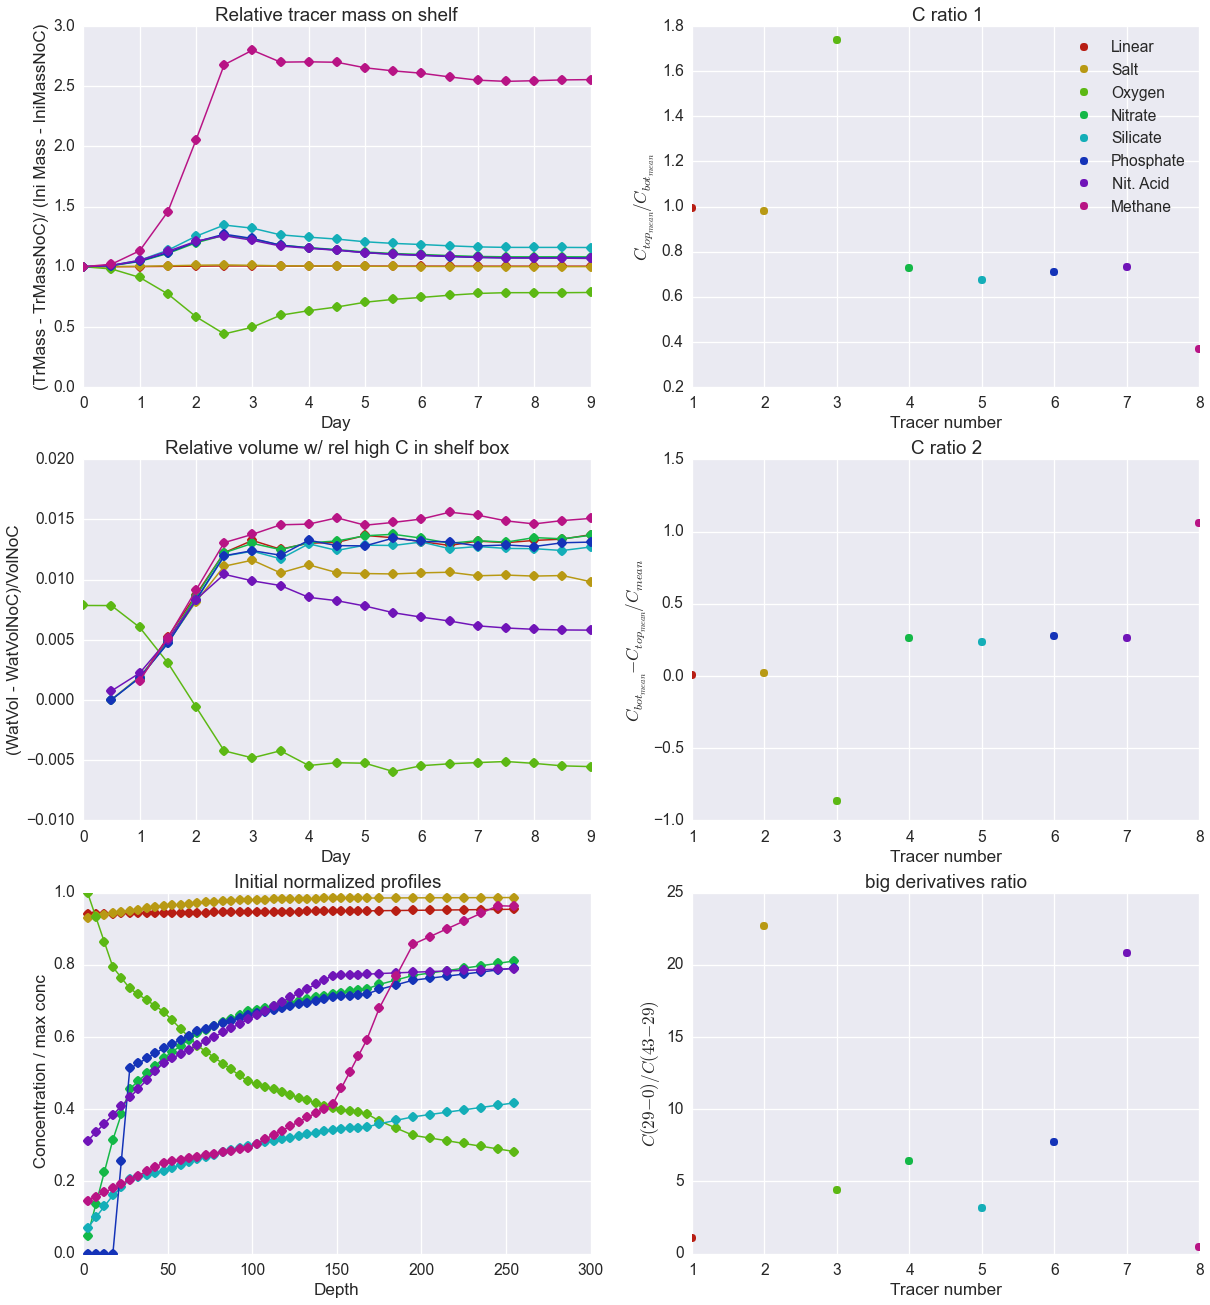

In [44]:
fig45=plt.figure(figsize=(20,22))
sns.set(context='talk', style='darkgrid', font='sans-serif', font_scale=1.2,rc={"lines.linewidth": 1.5})

times = np.arange(0,nt,1)


#with sns.color_palette('YlOrRd_r',8):
with sns.hls_palette(8, l=.4, s=.8):    
    #ax1 = plt.subplot(2,3,1)
    ax1 = plt.subplot2grid((3,2), (0,0), colspan=1,rowspan=1)
    
    line1 = ax1.plot(times/2.0, (TrMassTr1-Tr1NoC)/(TrMassTr1[0]-Tr1NoC[0]),'o-', label='Linear')
    line2 = ax1.plot(times/2.0, (TrMassTr2-Tr2NoC)/(TrMassTr2[0]-Tr2NoC[0]),'o-', label='Salt')
    line3 = ax1.plot(times/2.0, (TrMassTr3-Tr3NoC)/(TrMassTr3[0]-Tr3NoC[0]),'o-', label='Oxygen')
    line4 = ax1.plot(times/2.0, (TrMassTr4-Tr4NoC)/(TrMassTr4[0]-Tr4NoC[0]),'o-', label='Nitrate')
    line5 = ax1.plot(times/2.0, (TrMassTr5-Tr5NoC)/(TrMassTr5[0]-Tr5NoC[0]),'o-', label='Silicate')
    line6 = ax1.plot(times/2.0, (TrMassTr6-Tr6NoC)/(TrMassTr6[0]-Tr6NoC[0]),'o-', label='Phosphate')
    line7 = ax1.plot(times/2.0, (TrMassTr7-Tr7NoC)/(TrMassTr7[0]-Tr7NoC[0]),'o-', label='Nit. Acid')
    line8 = ax1.plot(times/2.0, (TrMassTr8-Tr8NoC)/(TrMassTr8[0]-Tr8NoC[0]),'o-', label='Methane')

    plt.ylabel('(TrMass - TrMassNoC)/ (Ini Mass - IniMassNoC) ')
    plt.xlabel('Day')
    plt.title('Relative tracer mass on shelf')
    
#with sns.color_palette('YlOrRd_r',8):
with sns.hls_palette(8, l=.4, s=.8):    
    #ax1 = plt.subplot(2,3,1)
    ax2 = plt.subplot2grid((3,2), (2,0), colspan=1,rowspan=1)
    
    line1 = ax2.plot(-rc[0:43], Tr1[0,0:43,50,180]/np.max(Tr1[0,:,50,180]) ,'o-', label='Linear')
    line2 = ax2.plot(-rc[0:43], Tr2[0,0:43,50,180]/np.max(Tr2[0,:,50,180]) ,'o-', label='Salt')
    line3 = ax2.plot(-rc[0:43], Tr3[0,0:43,50,180]/np.max(Tr3[0,:,50,180]) ,'o-', label='Oxygen')
    line4 = ax2.plot(-rc[0:43], Tr4[0,0:43,50,180]/np.max(Tr4[0,:,50,180]) ,'o-', label='Nitrate')
    line5 = ax2.plot(-rc[0:43], Tr5[0,0:43,50,180]/np.max(Tr5[0,:,50,180]) ,'o-', label='Silicate')
    line6 = ax2.plot(-rc[0:43], Tr6[0,0:43,50,180]/np.max(Tr6[0,:,50,180]) ,'o-', label='Phosphate')
    line7 = ax2.plot(-rc[0:43], Tr7[0,0:43,50,180]/np.max(Tr7[0,:,50,180]) ,'o-', label='Nit. Acid')
    line8 = ax2.plot(-rc[0:43], Tr8[0,0:43,50,180]/np.max(Tr8[0,:,50,180]) ,'o-', label='Methane')

    plt.ylabel(' Concentration / max conc')
    plt.xlabel('Depth')
    plt.title('Initial normalized profiles')

with sns.hls_palette(8, l=.4, s=.8):
    
    ax3 = plt.subplot2grid((3,2), (1,0))

    line1 = ax3.plot(times/2.0, (WatTr1-WatNoCTr1)/WatNoCTr3[0],'o-',label='Linear')
    line2 = ax3.plot(times/2.0, (WatTr2-WatNoCTr2)/WatNoCTr3[0],'o-', label='Salt')
    line3 = ax3.plot(times/2.0, (WatTr3-WatNoCTr3)/WatNoCTr3[0],'o-', label='Oxygen')
    line4 = ax3.plot(times/2.0, (WatTr4-WatNoCTr4)/WatNoCTr3[0],'o-', label='Nitrate')
    line5 = ax3.plot(times/2.0, (WatTr5-WatNoCTr5)/WatNoCTr3[0],'o-', label='Silicate')
    line6 = ax3.plot(times/2.0, (WatTr6-WatNoCTr6)/WatNoCTr3[0],'o-', label='Phosphate')
    line7 = ax3.plot(times/2.0, (WatTr7-WatNoCTr7)/WatNoCTr3[0],'o-', label='Nit. Acid')
    line8 = ax3.plot(times/2.0, (WatTr8-WatNoCTr8)/WatNoCTr3[0],'o-', label='Methane')
    
    plt.title('Relative volume w/ rel high C in shelf box')
    plt.ylabel('(WatVol - WatVolNoC)/VolNoC')
    plt.xlabel('Day')

    
with sns.hls_palette(8, l=.4, s=.8):
    #ax5 = plt.subplot(2,3,(5,6))
    ax5 = plt.subplot2grid((3,2), (0,1), colspan=1,rowspan=1)
    
    line1 = ax5.plot(1,(np.mean(Tr1[0,0:29,50,180])/np.mean(Tr1[0,29:43,50,180])),'o',markersize = 8, label='Linear')
    line2 = ax5.plot(2,(np.mean(Tr2[0,0:29,50,180])/np.mean(Tr2[0,29:43,50,180])),'o',markersize = 8, label='Salt')
    line3 = ax5.plot(3,(np.mean(Tr3[0,0:29,50,180])/np.mean(Tr3[0,29:43,50,180])),'o',markersize = 8, label='Oxygen')
    line4 = ax5.plot(4,(np.mean(Tr4[0,0:29,50,180])/np.mean(Tr4[0,29:43,50,180])),'o',markersize = 8, label='Nitrate')
    line5 = ax5.plot(5,(np.mean(Tr5[0,0:29,50,180])/np.mean(Tr5[0,29:43,50,180])),'o',markersize = 8, label='Silicate')
    line6 = ax5.plot(6,(np.mean(Tr6[0,0:29,50,180])/np.mean(Tr6[0,29:43,50,180])),'o',markersize = 8, label='Phosphate')
    line7 = ax5.plot(7,(np.mean(Tr7[0,0:29,50,180])/np.mean(Tr7[0,29:43,50,180])),'o',markersize = 8, label='Nit. Acid')
    line8 = ax5.plot(8,(np.mean(Tr8[0,0:29,50,180])/np.mean(Tr8[0,29:43,50,180])),'o',markersize = 8, label='Methane')
    
    plt.title('C ratio 1')
    
    plt.ylabel('$C_{top_{mean}}/C_{bot_{mean}}$')
    plt.xlabel('Tracer number')
    
     
with sns.hls_palette(8, l=.4, s=.8):
    #ax5 = plt.subplot(2,3,(5,6))
    ax6 = plt.subplot2grid((3,2), (2,1), colspan=1,rowspan=1)
    
    line1 = ax6.plot(1,(Tr1ini[29]-Tr1ini[0])/(Tr1ini[43]-Tr1ini[29]),'o',markersize = 8, label='Linear')
    line2 = ax6.plot(2,(Tr2ini[29]-Tr2ini[0])/(Tr2ini[43]-Tr2ini[29]),'o',markersize = 8, label='Salt')
    line3 = ax6.plot(3,(Tr3ini[29]-Tr3ini[0])/(Tr3ini[43]-Tr3ini[29]),'o',markersize = 8, label='Oxygen')
    line4 = ax6.plot(4,(Tr4ini[29]-Tr4ini[0])/(Tr4ini[43]-Tr4ini[29]),'o',markersize = 8, label='Nitrate')
    line5 = ax6.plot(5,(Tr5ini[29]-Tr5ini[0])/(Tr5ini[43]-Tr5ini[29]),'o',markersize = 8, label='Silicate')
    line6 = ax6.plot(6,(Tr6ini[29]-Tr6ini[0])/(Tr6ini[43]-Tr6ini[29]),'o',markersize = 8, label='Phosphate')
    line7 = ax6.plot(7,(Tr7ini[29]-Tr7ini[0])/(Tr7ini[43]-Tr7ini[29]),'o',markersize = 8, label='Nit. Acid')
    line8 = ax6.plot(8,(Tr8ini[29]-Tr8ini[0])/(Tr8ini[43]-Tr8ini[29]),'o',markersize = 8, label='Methane')
     
    #ax5.set_xlim(0,400)
    #ax5.set_ylim(-0.002,0.002)
    
    plt.title('big derivatives ratio')
    #plt.axhline(y=-150,linewidth=1, color='k', linestyle='--')
    #plt.axhline(y=-225,linewidth=1, color='k', linestyle='-')
    
    plt.ylabel('$C(29-0)/C(43-29)$')
    plt.xlabel('Tracer number')
    
with sns.hls_palette(8, l=.4, s=.8):
    #ax5 = plt.subplot(2,3,(5,6))
    ax7 = plt.subplot2grid((3,2), (1,1), colspan=1,rowspan=1)
    
    line1 = ax7.plot(1,(-np.mean(Tr1[0,0:29,50,180])+np.mean(Tr1[0,29:43,50,180]))/np.mean(Tr1[0,:,50,180]),'o',markersize = 8, label='Linear')
    line2 = ax7.plot(2,(-np.mean(Tr2[0,0:29,50,180])+np.mean(Tr2[0,29:43,50,180]))/np.mean(Tr2[0,:,50,180]),'o',markersize = 8, label='Salt')
    line3 = ax7.plot(3,(-np.mean(Tr3[0,0:29,50,180])+np.mean(Tr3[0,29:43,50,180]))/np.mean(Tr3[0,:,50,180]),'o',markersize = 8, label='Oxygen')
    line4 = ax7.plot(4,(-np.mean(Tr4[0,0:29,50,180])+np.mean(Tr4[0,29:43,50,180]))/np.mean(Tr4[0,:,50,180]),'o',markersize = 8, label='Nitrate')
    line5 = ax7.plot(5,(-np.mean(Tr5[0,0:29,50,180])+np.mean(Tr5[0,29:43,50,180]))/np.mean(Tr5[0,:,50,180]),'o',markersize = 8, label='Silicate')
    line6 = ax7.plot(6,(-np.mean(Tr6[0,0:29,50,180])+np.mean(Tr6[0,29:43,50,180]))/np.mean(Tr6[0,:,50,180]),'o',markersize = 8, label='Phosphate')
    line7 = ax7.plot(7,(-np.mean(Tr7[0,0:29,50,180])+np.mean(Tr7[0,29:43,50,180]))/np.mean(Tr7[0,:,50,180]),'o',markersize = 8, label='Nit. Acid')
    line8 = ax7.plot(8,(-np.mean(Tr8[0,0:29,50,180])+np.mean(Tr8[0,29:43,50,180]))/np.mean(Tr8[0,:,50,180]),'o',markersize = 8, label='Methane')
     
    #ax5.set_xlim(0,400)
    #ax5.set_ylim(-0.002,0.002)
    
    plt.title('C ratio 2')
    #plt.axhline(y=-150,linewidth=1, color='k', linestyle='--')
    #plt.axhline(y=-225,linewidth=1, color='k', linestyle='-')
    
    plt.ylabel('$C_{bot_{mean}}-C_{top_{mean}}/C_{mean}$')
    plt.xlabel('Tracer number')
    
        
#plt.tight_layout()

handles, labels = ax5.get_legend_handles_labels()
ax5.legend(handles, labels,loc=0)



#fig45.savefig('/ocean/kramosmu/Figures/WaterVolumeOverShelf/MassOverShelfIsoEffectTr1.eps', format='eps', dpi=1000, bbox_inches='tight')

        

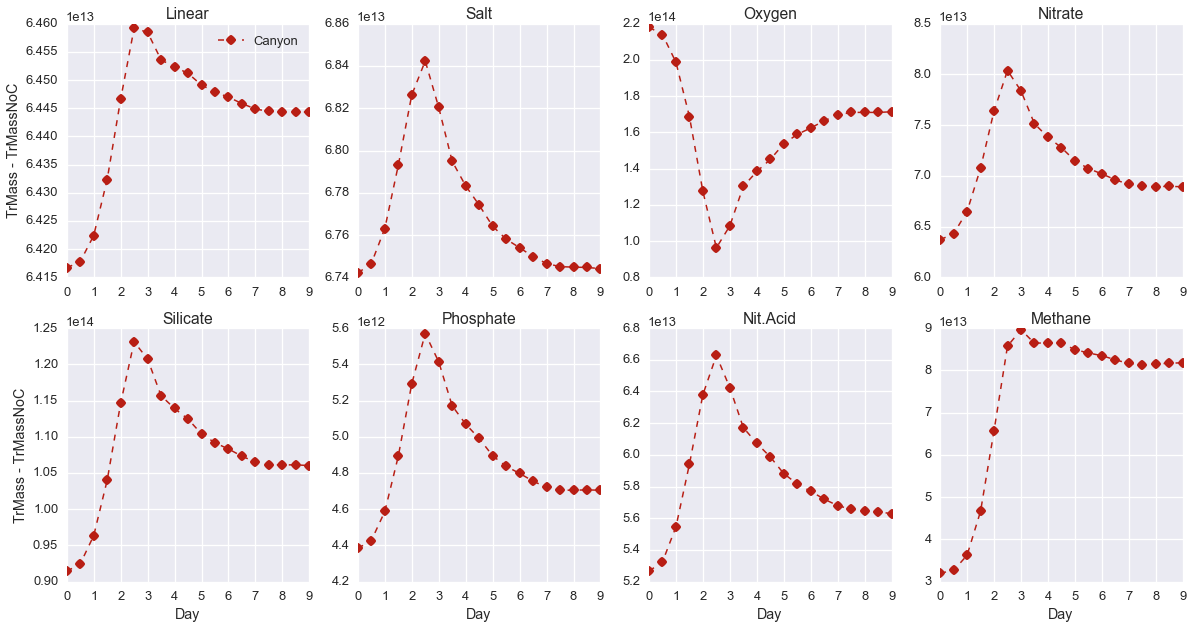

In [28]:
fig45=plt.figure(figsize=(20,10))
sns.set(context='talk', style='darkgrid', font='sans-serif', font_scale=1,rc={"lines.linewidth": 1.5})

times = np.arange(0,nt,1)

#with sns.color_palette('YlOrRd_r',8):
with sns.hls_palette(8, l=.4, s=.8):    
    ax1 = plt.subplot(2,4,1)

    #line1 = ax1.plot(times/2.0, TrMassTr1,'o--', label='Canyon')
    #line2 = ax1.plot(times/2.0, Tr1NoC,'o-', label='NoC')
    line1 = ax1.plot(times/2.0, TrMassTr1-Tr1NoC,'o--', label='Canyon')
    
    plt.ylabel('TrMass - TrMassNoC ')
    plt.title('Linear')

   
    ax2 = plt.subplot(2,4,2)

    #line1 = ax2.plot(times/2.0, TrMassTr2,'o--', label='Canyon')
    #line2 = ax2.plot(times/2.0, Tr2NoC,'o-', label='NoC')
    line1 = ax2.plot(times/2.0, TrMassTr2-Tr2NoC,'o--', label='Canyon')
    
    plt.title('Salt')

    ax3 = plt.subplot(2,4,3)

    #line1 = ax3.plot(times/2.0, TrMassTr3,'o--', label='Canyon')
    #line2 = ax3.plot(times/2.0, Tr3NoC,'o-', label='NoC')
    line1 = ax3.plot(times/2.0, TrMassTr3-Tr3NoC,'o--', label='Canyon')
    
    plt.title('Oxygen')

    ax4 = plt.subplot(2,4,4)

    #line1 = ax4.plot(times/2.0, TrMassTr4,'o--', label='Canyon')
    #line2 = ax4.plot(times/2.0, Tr4NoC,'o-', label='NoC')
    line1 = ax4.plot(times/2.0, TrMassTr4-Tr4NoC,'o--', label='Canyon')
    
    plt.title('Nitrate')

    ax5 = plt.subplot(2,4,5)

    #line1 = ax5.plot(times/2.0, TrMassTr5,'o--', label='Canyon')
    #line2 = ax5.plot(times/2.0, Tr5NoC,'o-', label='NoC')
    line1 = ax5.plot(times/2.0, TrMassTr5-Tr5NoC,'o--', label='Canyon')
    
    plt.ylabel('TrMass - TrMassNoC  ')
    plt.xlabel('Day')
    plt.title('Silicate')

    ax6 = plt.subplot(2,4,6)

    #line1 = ax6.plot(times/2.0, TrMassTr6,'o--', label='Canyon')
    #line2 = ax6.plot(times/2.0, Tr6NoC,'o-', label='NoC')
    line1 = ax6.plot(times/2.0, TrMassTr6-Tr6NoC,'o--', label='Canyon')
    
    
    plt.xlabel('Day')
    plt.title('Phosphate')

    ax7 = plt.subplot(2,4,7)

    #line1 = ax7.plot(times/2.0, TrMassTr7,'o--', label='Canyon')
    #line2 = ax7.plot(times/2.0, Tr7NoC,'o-', label='NoC')
    line1 = ax7.plot(times/2.0, TrMassTr7-Tr7NoC,'o--', label='Canyon')
    
    
    plt.xlabel('Day')
    plt.title('Nit.Acid')

    ax8 = plt.subplot(2,4,8)

    #line1 = ax8.plot(times/2.0, TrMassTr8,'o--', label='Canyon')
    #line2 = ax8.plot(times/2.0, Tr8NoC,'o-', label='NoC')
    line1 = ax8.plot(times/2.0, TrMassTr8-Tr8NoC,'o--', label='Canyon')
    
    
    plt.xlabel('Day')
    plt.title('Methane')

    
    
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, labels, loc=0)
   


#fig45.savefig('/ocean/kramosmu/Figures/WaterVolumeOverShelf/MassOverShelfIsoEffectTr1.eps', format='eps', dpi=1000, bbox_inches='tight')

        
        